In [3]:
!conda install nvidia/label/cuda-12.1.1::cuda-nvcc
!pip install transformers datasets peft trl accelerate kaggle packaging ninja tf-keras
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install wandb

Channels:
 - conda-forge
 - nvidia/label/cuda-12.1.1
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached wandb-0.21.1-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached gitpython-3.1.45-py3-none-any.whl.metadata (13 kB)
  Using cached sentry_sdk-2.35.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
Using cached wandb-0.21.1-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (22.4 MB)
Using cached gitpython-3.1.45-py3-none-any.whl (208 kB)
Using cached sentry_sdk-2.35.0-py2.py3-none-any.whl (363 kB)
Using cached gitdb-4.0.12-py3-none

In [5]:
!pip install flash-attn --no-build-isolation

  Using cached flash_attn-2.8.3-cp311-cp311-linux_x86_64.whl
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)


In [6]:

import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Set up API credentials (alternative to file placement)
os.environ['KAGGLE_USERNAME'] = 'YOUR_USERNAME'
os.environ['KAGGLE_KEY'] = 'YOUR_API_KEY'

# Initialize and authenticate
api = KaggleApi()
api.authenticate()

# Download the FinQA dataset
dataset_name = 'visalakshiiyer/question-answering-financial-data'
download_path = './finqa_data'

# Download and extract all files
api.dataset_download_files(dataset_name, path=download_path, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/visalakshiiyer/question-answering-financial-data


# Data Preprocessing for Fine-tuning
Transform the raw FinQA data into an instruction-following format suitable for Phi-4 training:

In [5]:
import json
from datasets import Dataset

def preprocess_finqa(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    processed_data = []
    for item in data:
        # Build context from pre_text, table, and post_text
        context = ""
        
        # Add pre_text if it exists
        if item.get("pre_text"):
            context += " ".join(item["pre_text"]) + "\n"
        
        # Add table if it exists
        if item.get("table"):
            table_text = "Table:\n"
            for row in item["table"]:
                table_text += " | ".join(map(str, row)) + "\n"
            context += table_text
        
        # Add post_text if it exists
        if item.get("post_text"):
            context += "\n" + " ".join(item["post_text"])

        # Extract question and answer from qa field
        question = item["qa"]["question"]
        answer = item["qa"]["exe_ans"]
        program_steps = item["qa"]["program"]

        # Process the reasoning program
        rationale = ""
        if isinstance(program_steps, list):
            # Join program steps with arrows
            rationale = " → ".join(program_steps)
        elif isinstance(program_steps, str):
            # If it's already a string, clean it up
            rationale = program_steps.replace("\n", " → ")

        # Format as single text string using Phi-4's chat template format
        formatted_text = (
            f"<|system|>\n"
            f"You are a financial assistant. Reason step-by-step to answer the user's question based on the provided context.<|end|>\n"
            f"<|user|>\n"
            f"Context:\n{context.strip()}\n\n"
            f"Question: {question}<|end|>\n"
            f"<|assistant|>\n"
            f"Rationale: {rationale}\n\n"
            f"Answer: {answer}<|end|>\n"
        )
        
        processed_data.append({"text": formatted_text})
    
    return processed_data

# Process datasets
train_data = preprocess_finqa('finqa_data/train.json')
dev_data = preprocess_finqa('finqa_data/dev.json')
train_dataset = Dataset.from_list(train_data)
eval_dataset = Dataset.from_list(dev_data)

# Check the format
print("Sample formatted text:")
print("="*50)
print(train_data[941]["text"])
print("="*50)
print(f"Total training examples: {len(train_data)}")
print(f"Total dev examples: {len(dev_data)}")


Sample formatted text:
<|system|>
You are a financial assistant. Reason step-by-step to answer the user's question based on the provided context.<|end|>
<|user|>
Context:
year ended december 31 , 2004 compared to year ended december 31 , 2003 the historical results of operations of pca for the years ended december 31 , 2004 and 2003 are set forth below : for the year ended december 31 , ( in millions ) 2004 2003 change .
Table:
( in millions ) | for the year ended december 31 , 2004 | for the year ended december 31 , 2003 | change
net sales | $ 1890.1 | $ 1735.5 | $ 154.6
income before interest and taxes | $ 140.5 | $ 96.9 | $ 43.6
interest expense net | -29.6 ( 29.6 ) | -121.8 ( 121.8 ) | 92.2
income ( loss ) before taxes | 110.9 | -24.9 ( 24.9 ) | 135.8
( provision ) benefit for income taxes | -42.2 ( 42.2 ) | 10.5 | -52.7 ( 52.7 )
net income ( loss ) | $ 68.7 | $ -14.4 ( 14.4 ) | $ 83.1

net sales net sales increased by $ 154.6 million , or 8.9% ( 8.9 % ) , for the year ended decemb

## Model Configuration and QLoRA Setup
Configure Phi-4 with LoRA (Low-Rank Adaptation) with FP16 precision 

In [6]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Load model and tokenizer
model_id = "microsoft/phi-4"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token


# Load in FP16 instead of 4-bit (better for A100)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,  # Use FP16 instead of 4-bit
    device_map="auto",
    trust_remote_code=True,
    attn_implementation="flash_attention_2",  # Faster attention
    use_cache=False,  # Critical: Set this to False for training
)


E0000 00:00:1755550282.431279   18379 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755550282.442409   18379 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755550282.482346   18379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755550282.482361   18379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755550282.482362   18379 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755550282.482364   18379 computation_placer.cc:177] computation placer already registered. Please check linka

## LoRA Configuration for Phi-4
Configure Low-Rank Adaptation targeting specific attention modules in Phi-4's architecture . The target modules for Phi-4 include the key attention and feed-forward network layers:

In [7]:
lora_config = LoraConfig(
    r=16,                    # Rank parameter
    lora_alpha=32,           # Alpha scaling factor
    lora_dropout=0.1,        # Dropout probability
    bias="none",             # Bias configuration
    task_type="CAUSAL_LM",   # Task type for causal language modeling
    target_modules=[
        "q_proj",            # Query projection
        "k_proj",            # Key projection
        "v_proj",            # Value projection
        "o_proj",            # Output projection
        "gate_proj",         # Gate projection (MLP)
        "up_proj",           # Up projection (MLP)
        "down_proj",         # Down projection (MLP)
        # "embed_tokens",      # Token embeddings
        # "lm_head",           # Language model head
    ]
)

model = get_peft_model(model, lora_config)

# This prevents the Trainer from trying to move the model again, which causes the error.
model.is_parallelizable = True
model.model_parallel = True

# Verify trainable parameters
model.print_trainable_parameters()


trainable params: 21,299,200 || all params: 14,680,806,400 || trainable%: 0.1451


## Training Configuration and Execution
Set up training arguments optimized for financial reasoning tasks with appropriate learning rates and batch sizes

In [8]:
from trl import SFTTrainer, SFTConfig

# Your TrainingArguments are well-configured. No changes needed here.
sft_config = SFTConfig(
    output_dir="./phi4-finqa",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    bf16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    gradient_checkpointing=True,
    remove_unused_columns=False,
    
    max_length=2048, 
    packing=False,
)

if sft_config.gradient_checkpointing: 
    model.enable_input_require_grads()
    print("[*] Gradient checkpointing enabled with input gradients.")



# Create and run trainer
trainer = SFTTrainer(
    model=model,
    processing_class=tokenizer,
    args=sft_config,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Start the training process
trainer.train()


# This ensures the tokenizer with the correct padding token is saved.
tokenizer.save_pretrained("./phi4-finqa-final")

# This saves the LoRA adapter weights correctly.
trainer.save_model("./phi4-finqa-final")
print(" Tokenizer and fine-tuned model adapters saved successfully to ./phi4-finqa-final")



[*] Gradient checkpointing enabled with input gradients.


Truncating eval dataset: 100%|██████████| 883/883 [00:00<00:00, 148219.89 examples/s]
wandb: Currently logged in as: neelaychoudhury1999 (neelaychoudhury1999-queen-mary-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
100,1.464500,1.453379
200,1.361800,1.376577
300,1.401600,1.354458
400,1.310000,1.342184
500,1.339900,1.334193
600,1.319800,1.326999
700,1.358500,1.321841
800,1.319200,1.316355
900,1.270800,1.312645
1000,1.231800,1.309465


 Tokenizer and fine-tuned model adapters saved successfully to ./phi4-finqa-final


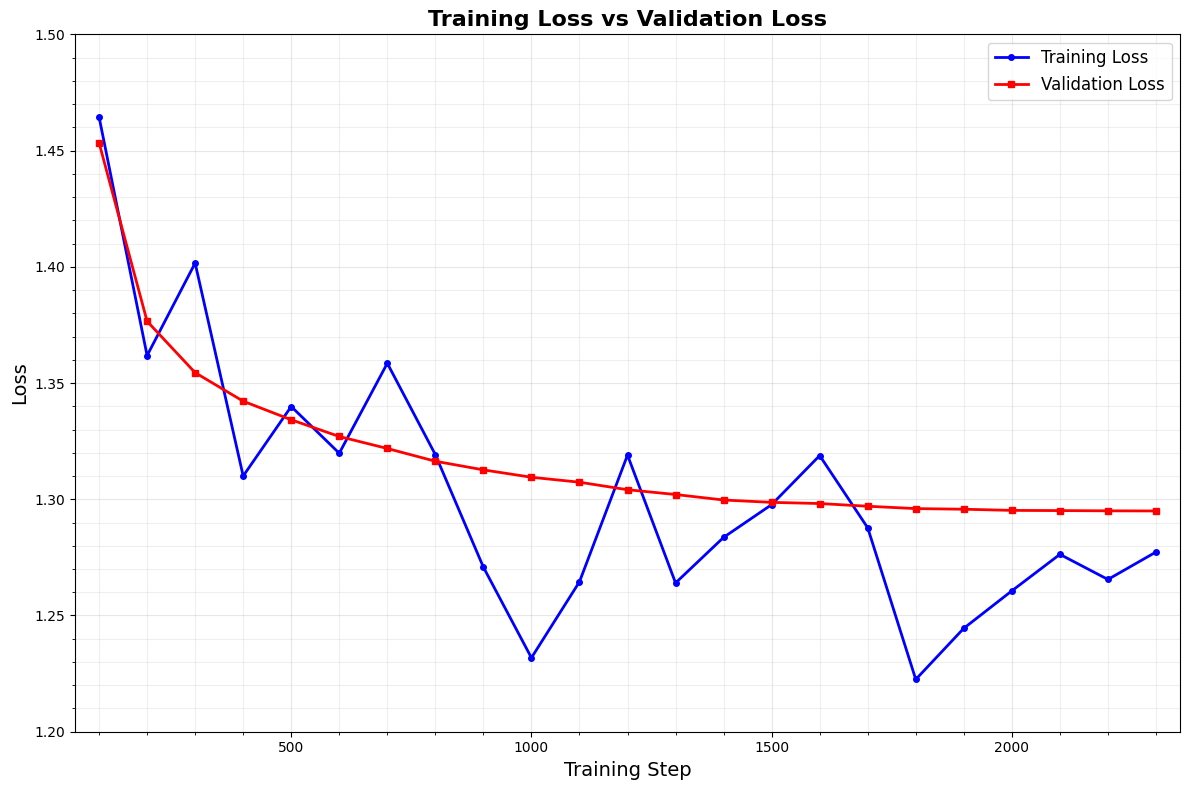

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Your training data
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300]

training_loss = [1.464500, 1.361800, 1.401600, 1.310000, 1.339900, 1.319800, 1.358500, 1.319200, 1.270800, 1.231800, 1.264500, 1.319000, 1.264000, 1.283600, 1.297700, 1.318800, 1.287700, 1.222500, 1.244500, 1.260600, 1.276300, 1.265500, 1.277300]

validation_loss = [1.453379, 1.376577, 1.354458, 1.342184, 1.334193, 1.326999, 1.321841, 1.316355, 1.312645, 1.309465, 1.307336, 1.304104, 1.302041, 1.299677, 1.298667, 1.298163, 1.296998, 1.295982, 1.295715, 1.295211, 1.295128, 1.295022, 1.294969]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(steps, training_loss, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
plt.plot(steps, validation_loss, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)

# Customize the plot
plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss vs Validation Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Set axis limits for better visualization
plt.xlim(50, 2350)
plt.ylim(1.2, 1.5)

# Add minor ticks
plt.minorticks_on()
plt.grid(which='minor', alpha=0.2)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')


# Evaluate the performance of models

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import re
import numpy as np
import torch
import os
import math
from typing import Dict, List, Optional, Tuple, Any, Union, TypedDict, Annotated, Literal

# Set up paths
model_path = "./phi4-finqa-final"  # Fine-tuned model path
base_model_path = "microsoft/phi-4"  # Original base model

# Check if fine-tuned model exists
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Fine-tuned model directory not found: {model_path}")

# Create offload directory
os.makedirs("./offload", exist_ok=True)

def load_base_model():
    """Load the original base model for comparison"""
    try:
        tokenizer = AutoTokenizer.from_pretrained(base_model_path)
        tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            base_model_path,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
            attn_implementation="flash_attention_2", 
            use_cache=True,
            offload_folder="./offload"
        )
        
        return model, tokenizer
    except Exception as e:
        print(f"Error loading base model: {e}")
        raise

def load_finetuned_model():
    """Load the fine-tuned PEFT model"""
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        tokenizer.pad_token = tokenizer.eos_token
        
        # Load base model first
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_path,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True,
            attn_implementation="flash_attention_2",
            use_cache=True,
            offload_folder="./offload"
        )
        
        # Load PEFT adapters
        model = PeftModel.from_pretrained(
            base_model,
            model_path,
            offload_folder="./offload"
        )
        
        return model, tokenizer
    except Exception as e:
        print(f"Error loading fine-tuned model: {e}")
        raise

def create_pipeline(model, tokenizer, model_name):
    """Create inference pipeline for a model"""
    return pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=200,        # Increased for complete rationale + answer
        do_sample=False,     
        repetition_penalty=1.1,    # Reduced from 1.2
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        return_full_text=False,    # Only return generated text, not input
    )

# Load both models
print("Loading base model...")
base_model, base_tokenizer = load_base_model()
base_pipe = create_pipeline(base_model, base_tokenizer, "base")
print("✓ Base model loaded successfully")

print("Loading fine-tuned model...")
finetuned_model, finetuned_tokenizer = load_finetuned_model()
finetuned_pipe = create_pipeline(finetuned_model, finetuned_tokenizer, "fine-tuned")
print("✓ Fine-tuned model loaded successfully")

# Load FinQA test dataset
def load_finqa_test_data(file_path):
    if not os.path.exists(file_path):
        print(f"Warning: Test file {file_path} not found. Using dummy data.")
        return [
            {
                "pre_text": ["Sample financial data"],
                "table": [["Revenue", "100"], ["Profit", "20"]],
                "post_text": ["Additional context"],
                "qa": {"question": "What is the revenue?", "exe_ans": "100"}
            }
        ]
    with open(file_path, 'r') as f:
        return json.load(f)

test_data = load_finqa_test_data('finqa_data/test.json')

def create_evaluation_prompt(item):
    """Create prompt in the exact same format as training data"""
    # Build context exactly like in training
    context = ""
    
    if item.get('pre_text'):
        if isinstance(item['pre_text'], list):
            context += " ".join(item['pre_text']) + "\n"
        else:
            context += item['pre_text'] + "\n"
    
    if item.get('table'):
        table_text = "Table:\n"
        for row in item['table']:
            table_text += " | ".join(map(str, row)) + "\n"
        context += table_text
    
    if item.get('post_text'):
        if isinstance(item['post_text'], list):
            context += "\n" + " ".join(item['post_text'])
        else:
            context += "\n" + item['post_text']
    
    question = item['qa']['question']
    
    # Create prompt in EXACTLY the same format as training, but stop at <|assistant|>
    prompt = (
        f"<|system|>\n"
        f"You are a financial assistant. Reason step-by-step to answer the user's question based on the provided context.<|end|>\n"
        f"<|user|>\n"
        f"Context:\n{context.strip()}\n\n"
        f"Question: {question}<|end|>\n"
        f"<|assistant|>\n"
    )
    
    return prompt, context

def extract_financial_answer(text: str) -> Optional[str]:
    """Enhanced extraction handling repetitive fine-tuned model output"""
    
    # Pattern 1: Standard "Answer: X" format
    first_answer_match = re.search(r"Answer:\s*(-?[\d,.]+)", text, re.IGNORECASE)
    if first_answer_match:
        return first_answer_match.group(1).replace(",", "").strip()
    
    # Pattern 2: Rationale followed by Answer
    rationale_match = re.search(r"Rationale:[^A]*?Answer:\s*(-?[\d,.]+)", text, re.DOTALL | re.IGNORECASE)
    if rationale_match:
        return rationale_match.group(1).replace(",", "").strip()
    
    # Pattern 3: Chain-of-thought operations
    operations = re.findall(r"(?:subtract|divide|multiply|add)\([^)]+\)\s*Answer:\s*(-?[\d,.]+)", text, re.IGNORECASE)
    if operations:
        return operations[0].replace(",", "").strip()  
    
    # Pattern 4: Any decimal number (for base model incomplete responses)
    decimal_numbers = re.findall(r"(-?[\d]+\.[\d]+)", text)
    if decimal_numbers:
        return decimal_numbers[-1]
    
    # Pattern 5: Any significant integer
    numbers = re.findall(r"(-?[\d,]+)", text)
    if numbers:
        for num in reversed(numbers):
            clean_num = num.replace(",", "")
            if len(clean_num) > 1:
                return clean_num
    
    return None

def normalize_number(num_str):
    """Normalize number string for comparison"""
    if not num_str:
        return None
    try:
        return float(str(num_str).replace(',', ''))
    except (ValueError, AttributeError):
        return None

def clean_model_response(response: str) -> str:
    """Enhanced cleaning for repetitive responses"""
    
    # Find first complete answer
    first_answer_pos = response.find("Answer:")
    if first_answer_pos != -1:
        # Find the end of the first answer line
        answer_line_end = response.find("\n", first_answer_pos)
        if answer_line_end != -1:
            # Look for next rationale - if found, truncate there
            next_rationale = response.find("Rationale:", answer_line_end)
            if next_rationale != -1:
                response = response[:next_rationale]
    
    # Remove special tokens and artifacts
    response = response.replace("<|end|>", "").replace("<|assistant|>", "").replace("</s>", "")
    
    # Clean excessive whitespace
    response = re.sub(r'\s+', ' ', response).strip()
    
    return response

def evaluate_sample(base_pipe, finetuned_pipe, item, sample_idx):
    """Evaluate both models on a single sample using standard text format"""
    
    print(f"\n{'='*100}")
    print(f"SAMPLE {sample_idx + 1}")
    print(f"{'='*100}")
    
    try:
        # Create evaluation prompt in the same format as training
        prompt, context = create_evaluation_prompt(item)
        
        # Display the question and context
        print(f"QUESTION: {item['qa']['question']}")
        print(f"GROUND TRUTH: {item['qa']['exe_ans']}")
        print(f"\nCONTEXT: {context[:200]}{'...' if len(context) > 200 else ''}")
        
        print(f"\n{'-'*100}")
        print("RUNNING BASE MODEL...")
        print(f"{'-'*100}")
        
        # Generate response from base model
        base_response_raw = base_pipe(prompt)[0]['generated_text']
        base_cleaned = clean_model_response(base_response_raw)
        base_pred_answer = extract_financial_answer(base_cleaned)
            
        print(f"BASE MODEL RESPONSE:")
        print(f"{base_response_raw}")
        print(f"\nBASE MODEL EXTRACTED ANSWER: {base_pred_answer}")
        
        print(f"\n{'-'*100}")
        print("RUNNING FINE-TUNED MODEL...")
        print(f"{'-'*100}")
        
        # Generate response from fine-tuned model
        finetuned_response_raw = finetuned_pipe(prompt)[0]['generated_text']
        finetuned_cleaned = clean_model_response(finetuned_response_raw)
        finetuned_pred_answer = extract_financial_answer(finetuned_cleaned)
        
        print(f"FINE-TUNED MODEL RESPONSE:")
        print(f"{finetuned_response_raw}")
        print(f"\nFINE-TUNED MODEL EXTRACTED ANSWER: {finetuned_pred_answer}")
        
        # Compare results
        true_answer = str(item['qa']['exe_ans'])
        base_exact_correct = base_pred_answer == true_answer
        ft_exact_correct = finetuned_pred_answer == true_answer
        
        # Check numerical accuracy
        base_numerical_correct = False
        ft_numerical_correct = False
        
        try:
            base_num = normalize_number(base_pred_answer)
            ft_num = normalize_number(finetuned_pred_answer)
            true_num = normalize_number(true_answer)
            
            if base_num is not None and true_num is not None:
                base_numerical_correct = math.isclose(base_num, true_num, rel_tol=1e-2)
                
            if ft_num is not None and true_num is not None:
                ft_numerical_correct = math.isclose(ft_num, true_num, rel_tol=1e-2)
            
        except (ValueError, ZeroDivisionError, TypeError):
            pass
        
        print(f"\n{'-'*100}")
        print("COMPARISON RESULTS:")
        print(f"{'-'*100}")
        print(f"Ground Truth: {true_answer}")
        print(f"Base Model: {base_pred_answer} {'✅' if base_exact_correct else '❌'}")
        print(f"Fine-tuned: {finetuned_pred_answer} {'✅' if ft_exact_correct else '❌'}")
        
        if ft_exact_correct and not base_exact_correct:
            print("🎯 WINNER: Fine-tuned model is correct, base model is wrong!")
        elif base_exact_correct and not ft_exact_correct:
            print("🎯 WINNER: Base model is correct, fine-tuned model is wrong!")
        elif base_exact_correct and ft_exact_correct:
            print("🎯 RESULT: Both models are correct!")
        else:
            print("🎯 RESULT: Both models are incorrect")
        
        print(f"Numerical Accuracy (±1%): Base: {'✅' if base_numerical_correct else '❌'}, Fine-tuned: {'✅' if ft_numerical_correct else '❌'}")
        
        return {
            'base': {
                'response': base_response_raw,
                'extracted_answer': base_pred_answer,
                'exact_correct': base_exact_correct,
                'numerical_correct': base_numerical_correct
            },
            'finetuned': {
                'response': finetuned_response_raw,
                'extracted_answer': finetuned_pred_answer,
                'exact_correct': ft_exact_correct,
                'numerical_correct': ft_numerical_correct
            },
            'ground_truth': true_answer,
            'question': item['qa']['question']
        }
        
    except Exception as e:
        print(f"Error processing sample {sample_idx + 1}: {e}")
        return None

def run_sequential_evaluation(base_pipe, finetuned_pipe, test_data, num_samples=10):
    """Run evaluation on both models sequentially for each sample"""
    
    print(f"\n{'='*100}")
    print(f"STARTING SEQUENTIAL MODEL COMPARISON ON {min(num_samples, len(test_data))} SAMPLES")
    print(f"{'='*100}")
    
    results = []
    base_exact_correct = 0
    ft_exact_correct = 0
    base_numerical_correct = 0
    ft_numerical_correct = 0
    both_exact_correct = 0
    both_numerical_correct = 0
    neither_exact_correct = 0
    neither_numerical_correct = 0
    ft_exact_wins = 0
    base_exact_wins = 0
    ft_numerical_wins = 0
    base_numerical_wins = 0
    
    for i in range(min(num_samples, len(test_data))):
        print(f"\nProcessing sample {i+1}/{min(num_samples, len(test_data))}")
        
        result = evaluate_sample(base_pipe, finetuned_pipe, test_data[i], i)
        
        if result:
            results.append(result)
            
            # Track exact match statistics
            if result['base']['exact_correct']:
                base_exact_correct += 1
            if result['finetuned']['exact_correct']:
                ft_exact_correct += 1
            if result['base']['exact_correct'] and result['finetuned']['exact_correct']:
                both_exact_correct += 1
            elif not result['base']['exact_correct'] and not result['finetuned']['exact_correct']:
                neither_exact_correct += 1
            elif result['finetuned']['exact_correct'] and not result['base']['exact_correct']:
                ft_exact_wins += 1
            elif result['base']['exact_correct'] and not result['finetuned']['exact_correct']:
                base_exact_wins += 1
            
            # Track numerical accuracy statistics
            if result['base']['numerical_correct']:
                base_numerical_correct += 1
            if result['finetuned']['numerical_correct']:
                ft_numerical_correct += 1
            if result['base']['numerical_correct'] and result['finetuned']['numerical_correct']:
                both_numerical_correct += 1
            elif not result['base']['numerical_correct'] and not result['finetuned']['numerical_correct']:
                neither_numerical_correct += 1
            elif result['finetuned']['numerical_correct'] and not result['base']['numerical_correct']:
                ft_numerical_wins += 1
            elif result['base']['numerical_correct'] and not result['finetuned']['numerical_correct']:
                base_numerical_wins += 1
    
    # Final summary
    print(f"\n{'='*100}")
    print("FINAL SUMMARY")
    print(f"{'='*100}")
    print(f"Total samples evaluated: {len(results)}")
    print(f"\n--- EXACT MATCH RESULTS ---")
    print(f"Base model exact correct: {base_exact_correct}/{len(results)} ({base_exact_correct/len(results)*100:.1f}%)")
    print(f"Fine-tuned model exact correct: {ft_exact_correct}/{len(results)} ({ft_exact_correct/len(results)*100:.1f}%)")
    print(f"Both exact correct: {both_exact_correct}/{len(results)} ({both_exact_correct/len(results)*100:.1f}%)")
    print(f"Neither exact correct: {neither_exact_correct}/{len(results)} ({neither_exact_correct/len(results)*100:.1f}%)")
    print(f"Fine-tuned exact wins: {ft_exact_wins}/{len(results)} ({ft_exact_wins/len(results)*100:.1f}%)")
    print(f"Base exact wins: {base_exact_wins}/{len(results)} ({base_exact_wins/len(results)*100:.1f}%)")
    
    print(f"\n--- NUMERICAL ACCURACY RESULTS (±1%) ---")
    print(f"Base model numerical correct: {base_numerical_correct}/{len(results)} ({base_numerical_correct/len(results)*100:.1f}%)")
    print(f"Fine-tuned model numerical correct: {ft_numerical_correct}/{len(results)} ({ft_numerical_correct/len(results)*100:.1f}%)")
    print(f"Both numerical correct: {both_numerical_correct}/{len(results)} ({both_numerical_correct/len(results)*100:.1f}%)")
    print(f"Neither numerical correct: {neither_numerical_correct}/{len(results)} ({neither_numerical_correct/len(results)*100:.1f}%)")
    print(f"Fine-tuned numerical wins: {ft_numerical_wins}/{len(results)} ({ft_numerical_wins/len(results)*100:.1f}%)")
    print(f"Base numerical wins: {base_numerical_wins}/{len(results)} ({base_numerical_wins/len(results)*100:.1f}%)")
    
    if ft_exact_correct > base_exact_correct:
        print(f"\n🎉 EXACT MATCH WINNER: Fine-tuned model! ({ft_exact_correct} vs {base_exact_correct})")
    elif base_exact_correct > ft_exact_correct:
        print(f"\n🎉 EXACT MATCH WINNER: Base model! ({base_exact_correct} vs {ft_exact_correct})")
    else:
        print(f"\n🤝 EXACT MATCH TIE: Both models performed equally well! ({base_exact_correct} each)")
    
    if ft_numerical_correct > base_numerical_correct:
        print(f"🎉 NUMERICAL ACCURACY WINNER: Fine-tuned model! ({ft_numerical_correct} vs {base_numerical_correct})")
    elif base_numerical_correct > ft_numerical_correct:
        print(f"🎉 NUMERICAL ACCURACY WINNER: Base model! ({base_numerical_correct} vs {ft_numerical_correct})")
    else:
        print(f"🤝 NUMERICAL ACCURACY TIE: Both models performed equally well! ({base_numerical_correct} each)")
    
    print(f"{'='*100}")
    
    return results

# Run evaluation
results = run_sequential_evaluation(base_pipe, finetuned_pipe, test_data, num_samples=100)
print(f"\n{'='*100}")
print("SEQUENTIAL EVALUATION COMPLETE")
print(f"{'='*100}")


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1755614721.156243    1293 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755614721.183182    1293 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755614721.373120    1293 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755614721.373147    1293 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755614721.373149    1293 computation_pl

Loading base model...


Loading checkpoint shards: 100%|██████████| 6/6 [01:15<00:00, 12.57s/it]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ Base model loaded successfully
Loading fine-tuned model...


Loading checkpoint shards: 100%|██████████| 6/6 [01:09<00:00, 11.60s/it]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✓ Fine-tuned model loaded successfully

STARTING SEQUENTIAL MODEL COMPARISON ON 100 SAMPLES

Processing sample 1/100

SAMPLE 1
QUESTION: what is the net change in net revenue during 2015 for entergy corporation?
GROUND TRUTH: 94.0

CONTEXT: entergy corporation and subsidiaries management 2019s financial discussion and analysis a result of the entergy louisiana and entergy gulf states louisiana business combination , results of operations...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the net change in net revenue for Entergy Corporation during 2015, we need to compare the net revenue figures for 2015 and 2014.

From the table provided:

- **2014 Net Revenue**: $5,735 million
- **2015 Net Revenue**: $5,829 million

The net change in net revenue is calculated as follows:

\[ \text{Net Change} = \text{2015 Net Revenue} - \text{2014 Net Revenue} \]

\[ \text{Net Change} = \$5,829 \, \text{million} - \$5,735 \, \text{million} \]

\[ \text{Net Change} = \$94 \, \text{million} \]

Therefore, the net change in net revenue during 2015 for Entergy Corporation was an increase of $94 million.

BASE MODEL EXTRACTED ANSWER: 94

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(5829, 5735)

Answer: 94.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 94.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 94.0
Base Model: 94 ❌
Fine-tuned: 94.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 2/100

SAMPLE 2
QUESTION: what percentage of total facilities as measured in square feet are leased?
GROUND TRUTH: 0.14464

CONTEXT: item 1b . unresolved staff comments not applicable . item 2 . properties as of december 26 , 2015 , our major facilities consisted of : ( square feet in millions ) united states countries total owned ...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of total facilities that are leased, follow these steps:

1. **Identify Total Leased Facilities**: From the table, the total leased facilities amount to 8.1 million square feet.

2. **Identify Total Facilities**: The total facilities, both owned and leased, amount to 56.0 million square feet.

3. **Calculate the Percentage**:
   \[
   \text{Percentage of Leased Facilities} = \left(\frac{\text{Total Leased Facilities}}{\text{Total Facilities}}\right) \times 100
   \]
   \[
   \text{Percentage of Leased Facilities} = \left(\frac{8.1}{56.0}\right) \times 100 \approx 14.46\%
   \]

Therefore, approximately 14.46% of the total facilities are leased.

BASE MODEL EXTRACTED ANSWER: 14.46

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(8.1, 56.0)

Answer: 0.14464<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.14464

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.14464
Base Model: 14.46 ❌
Fine-tuned: 0.14464 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 3/100

SAMPLE 3
QUESTION: what is the percentage change in cash flow hedges in 2011 compare to the 2010?
GROUND TRUTH: 0.09864

CONTEXT: undesignated hedges was $ 41.2 million and $ 42.1 million , respectively . the fair value of these hedging instruments in the company 2019s consolidated balance sheets as of october 29 , 2011 and octo...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in cash flow hedges between 2011 and 2010, follow these steps:

1. **Identify the Notional Amounts**: 
   - For 2011, the notional amount of cash flow hedges is $153.7 million.
   - For 2010, the notional amount of cash flow hedges is $139.9 million.

2. **Calculate the Change**:
   \[
   \text{Change} = \text{Notional Amount in 2011} - \text{Notional Amount in 2010}
   \]
   \[
   \text{Change} = 153.7\, \text{million} - 139.9\, \text{million} = 13.8\, \text{million}
   \]

3. **Calculate the Percentage Change**:
   \[
   \text{Percentage Change} = \left( \frac{\text

BASE MODEL EXTRACTED ANSWER: 13.8

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(153.7, 139.9), divide(#0, 139.9)

Answer: 0.0966<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.0966

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.09864
Base Model: 13.8 ❌
Fine-tuned: 0.0966 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 4/100

SAMPLE 4
QUESTION: what portion of total purchase price is related to stock awards?
GROUND TRUTH: 0.02899

CONTEXT: chairman and a director of the board of fis as well as the chairman of the board of lps . effective march 1 , 2010 , mr . kennedy and the company mutually agreed that he would no longer serve as an ex...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
--------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the portion of the total purchase price related to stock awards, follow these steps:

1. **Identify the Total Purchase Price**: According to the table, the total purchase price for the Metavante acquisition was $4,187.8 million.

2. **Identify the Value Related to Stock Awards**: The value attributed to Metavante stock awards is $121.4 million.

3. **Calculate the Portion Related to Stock Awards**:
   - Use the formula: 
     \[
     \text{Portion related to stock awards} = \left( \frac{\text{Value of stock awards}}{\text{Total purchase price}} \right) \times 100
     \]
   - Substitute the known values:
     \[
     \text{Portion related to stock awards} = \left( \frac{121.4}{4187.8} \right) \times 100
     \]

4. **Perform the Calculation

BASE MODEL EXTRACTED ANSWER: 4187.8

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(121.4, 4187.8)

Answer: 0.02902<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.02902

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.02899
Base Model: 4187.8 ❌
Fine-tuned: 0.02902 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 5/100

SAMPLE 5
QUESTION: what was the difference in percentage cumulative total shareholder return on masco common stock versus the s&p 500 index for the five year period ended 2017?
GROUND TRUTH: 1.1197

CONTEXT: performance graph the table below compares the cumulative total shareholder return on our common stock with the cumulative total return of ( i ) the standard & poor's 500 composite stock index ( "s&p ...

------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the difference in percentage cumulative total shareholder return between Masco common stock and the S&P 500 Index over the five-year period ending December 31, 2017, we need to calculate the percentage returns for both and then determine their difference.

1. **Calculate the Percentage Return for Masco Common Stock:**

   - Initial Investment in 2012: $100
   - Value at End of 2017: $318.46

   \[
   \text{Percentage Return for Masco} = \left(\frac{\text{Final Value} - \text{Initial Value}}{\text{Initial Value}}\right) \times 100
   \]

   \[
   \text{Percentage Return for Masco} = \left(\frac{318.46 - 100}{100}\right) \times 100 = 218.46\%
   \]

2. **Calculate the Percentage Return for the S&P 500 Index:**



BASE MODEL EXTRACTED ANSWER: 218.46

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(318.46, const_100), divide(#0, const_100)

Answer: 2.1846<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 2.1846

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1.1197
Base Model: 218.46 ❌
Fine-tuned: 2.1846 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 6/100

SAMPLE 6
QUESTION: what was the percentage change in total rental expense under operating leases from july 2 , 2005 to july 1 , 2006?
GROUND TRUTH: 0.06757

CONTEXT: total debt total debt at july 1 , 2006 was $ 1762692000 , of which approximately 75% ( 75 % ) was at fixed rates averaging 6.0% ( 6.0 % ) with an average life of 19 years , and the remainder was at fl...

-----------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in total rental expense under operating leases from July 2, 2005, to July 1, 2006, we need to follow these steps:

1. **Identify the Rental Expenses**:
   - Total rental expense for fiscal 2005 (ending July 2, 2005): $92,710,000
   - Total rental expense for fiscal 2006 (ending July 1, 2006): $100,690,000

2. **Calculate the Change in Expense**:
   \[
   \text{Change} = \text{Rental Expense in 2006} - \text{Rental Expense in 2005}
   \]
   \[
   \text{Change} = \$100,690,000 - \$92,710,000 = \$7,980,000
   \]

3. **Calculate the Percentage Change**:
   \[
   \text{Percentage Change}

BASE MODEL EXTRACTED ANSWER: 7980000

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(100690000, 92710000), divide(#0, 92710000)

Answer: 0.0863<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.0863

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.06757
Base Model: 7980000 ❌
Fine-tuned: 0.0863 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 7/100

SAMPLE 7
QUESTION: what percent of total recourse debt is current?
GROUND TRUTH: 0.10039

CONTEXT: the aes corporation notes to consolidated financial statements 2014 ( continued ) december 31 , 2010 , 2009 , and 2008 recourse debt as of december 31 , 2010 is scheduled to reach maturity as set fort...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine what percentage of the total recourse debt is considered "current" as of December 31, 2010, we need to identify the portion of the debt maturing within one year from this date.

### Step-by-Step Calculation:

1. **Identify Current Maturities:**
   - The current maturities are those debts that will mature within one year from December 31, 2010.
   - According to the table, the annual maturities for 2011 are $463 million.

2. **Total Recourse Debt:**
   - The total recourse debt as of December 31, 2010, is $4,612 million.

3. **Calculate Percentage of Current Maturities:**
   - Use the formula: 
     \[
     \text{Percentage of Current Maturities} = \left( \frac{\text{Current Maturities}}{\text{Total Recourse Debt}} \right) \times 100

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-----------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(463, 4612)

Answer: 0.10044<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.10044

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.10039
Base Model: 100 ❌
Fine-tuned: 0.10044 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 8/100

SAMPLE 8
QUESTION: what percentage of future minimum rental payments are due in 2018?
GROUND TRUTH: 0.11689

CONTEXT: the goldman sachs group , inc . and subsidiaries notes to consolidated financial statements commercial lending . the firm 2019s commercial lending commitments are extended to investment-grade and non-...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
----------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of future minimum rental payments due in 2018, we need to follow these steps:

1. **Identify the total future minimum rental payments**: According to the table, the total future minimum rental payments from 2016 to "thereafter" is $2,575 million.

2. **Identify the future minimum rental payment for 2018**: The table shows that the future minimum rental payment for 2018 is $301 million.

3. **Calculate the percentage**: Use the formula for percentage calculation:

   \[
   \text{Percentage} = \left( \frac{\text{Future Minimum Rental Payment for 2018}}{\text{Total Future Minimum Rental Payments}} \right) \times 100
   \]

   Substituting the values:

   \[
   \text{Percentage} = \left( \frac{301}{2575} \right) \times 100 \approx 11.69\%
   \

BASE MODEL EXTRACTED ANSWER: 11.69

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-----------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(301, 2575)

Answer: 0.11691<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.11691

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.11689
Base Model: 11.69 ❌
Fine-tuned: 0.11691 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 9/100

SAMPLE 9
QUESTION: did altria outperform the s&p 500?
GROUND TRUTH: yes

CONTEXT: 2011 2012 2013 2014 2015 2016 comparison of five-year cumulative total shareholder return altria group , inc . altria peer group s&p 500 part ii item 5 . market for registrant 2019s common equity , re...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
--------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine if Altria Group, Inc. outperformed the S&P 500 over the specified period, we need to compare their respective cumulative total shareholder returns from December 2011 to December 2016.

Here is the data provided:

- **Altria Group, Inc.:**
  - Initial value in December 2011: $100.00
  - Final value in December 2016: $286.61

- **S&P 500:**
  - Initial value in December 2011: $100.00
  - Final value in December 2016: $198.09

Now, let's calculate the percentage increase for both:

1. **Altria Group, Inc.:**
   \[
   \text{Percentage Increase} = \left(\frac{\text{Final Value} - \text{Initial Value}}{\text{Initial Value}}\right) \times 100
   \]
   \[
   =

BASE MODEL EXTRACTED ANSWER: 198.09

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: greater(286.61, 198.09)

Answer: yes<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 198.09

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: yes
Base Model: 198.09 ❌
Fine-tuned: 198.09 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 10/100

SAMPLE 10
QUESTION: what was the change in unrecognized tax benefits from the end of 2014 to the end of 2015?
GROUND TRUTH: -35.0

CONTEXT: comcast corporation changes in our net deferred tax liability in 2015 that were not recorded as deferred income tax expense are primarily related to decreases of $ 28 million associated with items inc...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the change in unrecognized tax benefits from the end of 2014 to the end of 2015, we need to compare the balance of unrecognized tax benefits at December 31, 2014, with the balance at December 31, 2015.

From the table provided:

- The balance of unrecognized tax benefits at January 1, 2015, was $1,171 million.
- The balance of unrecognized tax benefits at December 31, 2015, was $1,136 million.

The change in unrecognized tax benefits from the end of 2014 to the end of 2015 is calculated as follows:

\[ \text{Change} = \text{Balance at December 31, 2015} - \text{Balance at December 31, 2014} \]

\[ \text{Change} = \$1,136 \, \text{million} - \$1,171 \, \text{million} \]

\[ \

BASE MODEL EXTRACTED ANSWER: 1171

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(1136, 1171)

Answer: -35.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -35.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -35.0
Base Model: 1171 ❌
Fine-tuned: -35.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 11/100

SAMPLE 11
QUESTION: what is the growth rate in the balance of standby letters of credit from 2006 to 2007?
GROUND TRUTH: -0.04365

CONTEXT: note 10 . commitments and contingencies off-balance sheet commitments and contingencies : credit-related financial instruments include indemnified securities financing , unfunded commitments to extend...

----------------------------------------------------------------------------------------------------
RUNNING BASE 

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the growth rate in the balance of standby letters of credit from 2006 to 2007, follow these steps:

1. **Identify the values for each year**:
   - Standby letters of credit in 2006: $4,926 million
   - Standby letters of credit in 2007: $4,711 million

2. **Calculate the change in value**:
   \[
   \text{Change} = \text{Value in 2007} - \text{Value in 2006} = 4,711 - 4,926 = -215 \text{ million}
   \]

3. **Calculate the growth rate** using the formula:
   \[
   \text{Growth Rate} = \left(\frac{\text{Change}}{\text{Value in 2006}}\right) \times 100
   \]
   \[
   \text{Growth Rate} = \

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(4711, 4926), divide(#0, 4926)

Answer: -0.04395<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -0.04395

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.04365
Base Model: 100 ❌
Fine-tuned: -0.04395 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 12/100

SAMPLE 12
QUESTION: what is the debt-to-asset ratio?
GROUND TRUTH: 0.22429

CONTEXT: other items on our consolidated financial statements have been appropriately adjusted from the amounts provided in the earnings release , including a reduction of our full year 2016 gross profit and i...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-----------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the debt-to-asset ratio, we need to use the formula:

\[
\text{Debt-to-Asset Ratio} = \frac{\text{Total Debt}}{\text{Total Assets}}
\]

We will calculate this ratio for each year using the data provided in the table.

### Calculations:

1. **For December 31, 2016:**
   - Total Debt = $817,388 (in thousands)
   - Total Assets = $3,644,331 (in thousands)

   \[
   \text{Debt-to-Asset Ratio}_{2016} = \frac{817,388}{3,644,331} \approx 0.2243 \text{ or } 22.43\%
   \]

2. **For December 31, 2015:**
   - Total Debt = $666,070 (in thousands)
   - Total Assets = $2,865,970 (in thousands)

  

BASE MODEL EXTRACTED ANSWER: 22.43

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(817388, 3644331)

Answer: 0.22427<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.22427

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.22429
Base Model: 22.43 ❌
Fine-tuned: 0.22427 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 13/100

SAMPLE 13
QUESTION: what portion of the total noncancelable future lease commitments are due in fiscal year of 2019?
GROUND TRUTH: 0.24566

CONTEXT: some operating leases require payment of property taxes , insurance , and maintenance costs in addition to the rent payments . contingent and escalation rent in excess of minimum rent payments and sub...

----------------------------------------------------------------------------------------------------
RUNNING BASE MOD

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the portion of the total noncancelable future lease commitments that are due in fiscal year 2019, follow these steps:

1. **Identify Total Noncancelable Future Lease Commitments**: According to the table, the total noncancelable future lease commitments amount to $559.3 million.

2. **Determine Operating Leases Due in Fiscal Year 2019**: The table specifies that $137.4 million of operating leases are due in fiscal year 2019.

3. **Calculate the Portion for Fiscal Year 2019**:
   \[
   \text{Portion for Fiscal Year 2019} = \frac{\text{Operating Leases for Fiscal Year 2019}}{\text{Total Noncancelable Future Lease Commitments}}
   \]
   \[
   \text{Portion for Fiscal Year 2019} = \frac{137.4}{559.3}
   \]

4. **Perform the Calculation**:


BASE MODEL EXTRACTED ANSWER: 559.3

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(137.4, 559.3)

Answer: 0.24557<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.24557

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.24566
Base Model: 559.3 ❌
Fine-tuned: 0.24557 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 14/100

SAMPLE 14
QUESTION: was the five year total return of the 2019 peer group greater than the 2018 peer group?
GROUND TRUTH: no

CONTEXT: 2 0 1 9 a n n u a l r e p o r t1 6 performance graph the following chart presents a comparison for the five-year period ended june 30 , 2019 , of the market performance of the company 2019s common sto...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-----------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine whether the five-year total return of the 2019 peer group was greater than that of the 2018 peer group, we need to compare their respective total returns as given in the table.

Here are the relevant figures from the table:

- **2019 Peer Group Total Return (June 30, 2019):** 281.09%
- **2018 Peer Group Total Return (June 30, 2019):** 286.22%

The total return represents how much an initial investment of $100 would have grown over the five-year period ending June 30, 2019.

Now, let's compare these two values:

- The 2019 peer group had a total return of 281.09%.
- The 2018 peer group had a total return of 286.22%.

Since 281.09% (2019 peer group) is less than 286.22% (2018 peer group), the five-year total return

BASE MODEL EXTRACTED ANSWER: 286.22

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(281.09, const_100), divide(#0, const_100)

Answer: 1.8109<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1.8109

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: no
Base Model: 286.22 ❌
Fine-tuned: 1.8109 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 15/100

SAMPLE 15
QUESTION: what was the percentage change in deferred tax assets and regulatory assets from 2013 to 2014
GROUND TRUTH: 0.01714

CONTEXT: three-year period determined by reference to the ownership of persons holding five percent ( 5% ( 5 % ) ) or more of that company 2019s equity securities . if a company undergoes an ownership change a...

----------------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in deferred tax assets and regulatory assets from 2013 to 2014, we need to determine the difference in amounts between these two years and then express this difference as a percentage of the 2013 value.

From the context:

- The reduction in deferred tax assets and the corresponding increase in regulatory assets amounted to $6,348 in 2014.
- In 2013, the same figures were $6,241.

**Step-by-step Calculation:**

1. **Determine the Change in Amount:**
   \[
   \text{Change} = \$6,348 - \$6,241 = \$107
   \]

2. **Calculate the Percentage Change:**
   \[
   \text{Percentage Change} = \left( \frac{\text{Change}}{\text{Amount in 2013}} \right) \times 100
   \]
   \[
   \text{Percentage Change} = \left(

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(6348, 6241), divide(#0, 6241)

Answer: 0.01602<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.01602

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.01714
Base Model: 100 ❌
Fine-tuned: 0.01602 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 16/100

SAMPLE 16
QUESTION: what was the average net annual change in discounted future net cash flows ( in millions ) for the years 2011 , 2010 , and 2009?
GROUND TRUTH: 3297.66667

CONTEXT: supplementary information on oil and gas producing activities ( unaudited ) changes in the standardized measure of discounted future net cash flows ( in millions ) 2011 2010 2009 .
Table:
( in million...

---------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the average net annual change in discounted future net cash flows for the years 2011, 2010, and 2009, we need to follow these steps:

1. **Identify the Net Change for Each Year:**
   - For 2011, the net change is \( \$4,648 \) million.
   - For 2010, the net change is \( \$3,625 \) million.
   - For 2009, the net change is \( \$1,620 \) million.

2. **Calculate the Total Net Change Over the Three Years:**
   \[
   4,648 + 3,625 + 1,620 = 9,893 \text{ million}
   \]

3. **Determine the Number of Years:**
   There are 3 years (2011, 2010, and 2009).

4. **Calculate the Average Net Annual Change:**
   \[
   \

BASE MODEL EXTRACTED ANSWER: 2009

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(4648, 3625), add(#0, 1620), divide(#1, const_3)

Answer: 3299.33333<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 3299.33333

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 3297.66667
Base Model: 2009 ❌
Fine-tuned: 3299.33333 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 17/100

SAMPLE 17
QUESTION: assuming each continent has the same number of destinations , approximately how many destinations does each continent have?
GROUND TRUTH: 65.0

CONTEXT: notes to the consolidated financial statements note 1 . general description of business we are a global cruise company . we own royal caribbean international , celebrity cruises , pullmantur , azamara...

------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the approximate number of destinations per continent, follow these steps:

1. **Identify Total Destinations**: According to the context, there are approximately 455 destinations across all seven continents.

2. **Determine Number of Continents**: There are seven continents.

3. **Calculate Destinations Per Continent**:
   - Divide the total number of destinations by the number of continents.
   \[
   \text{Destinations per continent} = \frac{455}{7}
   \]

4. **Perform the Calculation**:
   \[
   \frac{455}{7} = 65
   \]

Therefore, assuming each continent has the same number of destinations, each continent has approximately 65 destinations.

BASE MODEL EXTRACTED ANSWER: 65

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(455, const_7)

Answer: 65.00000<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 65.00000

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 65.0
Base Model: 65 ❌
Fine-tuned: 65.00000 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 18/100

SAMPLE 18
QUESTION: what was the average net revenue between 2016 and 2017 in millions
GROUND TRUTH: 705.25

CONTEXT: entergy mississippi , inc . management 2019s financial discussion and analysis results of operations net income 2017 compared to 2016 net income increased $ 0.8 million primarily due to higher other i...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the average net revenue between 2016 and 2017, we need to calculate the mean of the net revenues for these two years.

1. **Net Revenue for 2016**: $705.4 million
2. **Net Revenue for 2017**: $703.1 million

Now, add the net revenues for both years:

\[ 
705.4 + 703.1 = 1408.5 \text{ million}
\]

Next, divide the total by 2 to find the average:

\[ 
\frac{1408.5}{2} = 704.25 \text{ million}
\]

Therefore, the average net revenue between 2016 and 2017 was $704.25 million.

BASE MODEL EXTRACTED ANSWER: 704.25

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(705.4, 703.1), divide(#0, const_2)

Answer: 704.25<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 704.25

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 705.25
Base Model: 704.25 ❌
Fine-tuned: 704.25 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 19/100

SAMPLE 19
QUESTION: the combined amount of accrued interest and penalties related to tax positions taken on our tax returns and included in non-current income taxes payable was what percent of the total ending balance as of november 28 2008?
GROUND TRUTH: 0.10964

CONTEXT: summary fin 48 changes during fiscal 2008 , our aggregate changes in our total gross amount of unrecognized tax benefits are summarized as follows: .
Table:
beginning balance as of dece

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the percentage of the combined amount of accrued interest and penalties relative to the total ending balance as of November 28, 2008, follow these steps:

1. **Identify the relevant figures:**
   - Combined amount of accrued interest and penalties: $15.3 million.
   - Ending balance of unrecognized tax benefits as of November 28, 2008: $139.549 million.

2. **Calculate the percentage:**

   \[
   \text{Percentage} = \left( \frac{\text{Accrued Interest and Penalties}}{\text{Ending Balance}} \right) \times 100
   \]

   \[
   \text{Percentage} = \left( \frac{15.3}{139.549} \right) \times 100
   \]

3. **Perform the calculation:**

   \[
   \text{Percentage} \approx 10.96\%
   \]

Therefore, the

BASE MODEL EXTRACTED ANSWER: 10.96

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(15.3, 139.549)

Answer: 0.10978<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.10978

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.10964
Base Model: 10.96 ❌
Fine-tuned: 0.10978 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 20/100

SAMPLE 20
QUESTION: in 2010 and 2009 , what was the total fair value in billions of assets segregated for the benefit of securities and futures brokerage customers?
GROUND TRUTH: 68.9

CONTEXT: jpmorgan chase & co./2010 annual report 273 the following table presents the u.s . and non-u.s . components of income before income tax expense/ ( benefit ) and extraordinary gain for the years ended ...

--------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the total fair value in billions of assets segregated for the benefit of securities and futures brokerage customers in 2010 and 2009, we need to consider both the cash and securities mentioned in the context.

For December 31, 2010:
- Cash segregated: $25.0 billion
- Securities with a fair value segregated: $9.7 billion

Total fair value for 2010 = Cash + Securities  
= $25.0 billion + $9.7 billion  
= $34.7 billion

For December 31, 2009:
- Cash segregated: $24.0 billion
- Securities with a fair value segregated: $10.2 billion

Total fair value for 2009 = Cash + Securities  
= $24.0 billion + $10.2 billion  
= $34.2 billion

Therefore, the total fair value in billions of assets segregated for the benefit of securities and futures brokerage customers was $34.7 billion in

BASE MODEL EXTRACTED ANSWER: 34.7

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(25.0, 24.0)

Answer: 49.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 49.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 68.9
Base Model: 34.7 ❌
Fine-tuned: 49.0 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 21/100

SAMPLE 21
QUESTION: what was the percentage change in the commercial mortgage loans designated for sale at fair value from 2008 to 2009
GROUND TRUTH: -0.08422

CONTEXT: residential mortgage-backed securities at december 31 , 2012 , our residential mortgage-backed securities portfolio was comprised of $ 31.4 billion fair value of us government agency-backed securities...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODE

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage change in the commercial mortgage loans designated for sale at fair value from 2008 to 2009, we need to follow these steps:

1. **Identify the relevant data**: The problem states that PNC Financial Services Group stopped originating commercial mortgage loans held for sale designated at fair value in 2008. Therefore, any changes between 2008 and 2009 would be due to sales or adjustments rather than new originations.

2. **Find the values for 2008 and 2009**:
   - We know the balance at December 31, 2011, was $843 million.
   - At December 31, 2012, it was $772 million.
   - Sales in 2012 were $32 million, and in 2011 they were $25 million.

3. **Calculate the balance at the end of 2009**:
   - Start with the 2011 balance: $843 million.
   - Add

BASE MODEL EXTRACTED ANSWER: 843

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
---------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(843, 772), divide(#0, 772)

Answer: 0.09057<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.09057

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.08422
Base Model: 843 ❌
Fine-tuned: 0.09057 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 22/100

SAMPLE 22
QUESTION: what was the difference in percentage cumulative 5-year total shareholder return on common stock fidelity national information services , inc . compared to the s&p 500 for the period ending 12/16?
GROUND TRUTH: 1.1363

CONTEXT: there were no share repurchases in 2016 . stock performance graph the graph below matches fidelity national information services , inc.'s cumulative 5-year total shareholder return on common stock wit...

-------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the difference in percentage cumulative 5-year total shareholder return between Fidelity National Information Services, Inc. and the S&P 500 for the period ending December 31, 2016, we need to compare their respective returns over that period.

1. **Calculate the Cumulative Total Shareholder Return for Each:**

   - **Fidelity National Information Services, Inc.:**
     - Initial value at 12/31/2011 = $100.00
     - Final value at 12/31/2016 = $311.81
     - Cumulative return = \(\frac{311.81 - 100.00}{100.00} \times 100\% = 211.81\%\)

   - **S&P 500:**
     - Initial value at 12/31/2011 = $100.00
     - Final value at 12/31/2016 = $198.18
     - Cumulative

BASE MODEL EXTRACTED ANSWER: 198.18

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(311.81, const_100), divide(#0, const_100)

Answer: 2.1181<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 2.1181

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1.1363
Base Model: 198.18 ❌
Fine-tuned: 2.1181 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 23/100

SAMPLE 23
QUESTION: for the quarter ended march 312015 what was the percentage change in the share price from the highest to the lowest
GROUND TRUTH: 0.09302

CONTEXT: part ii item 5 . market for registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following table presents reported quarterly high and low per shar...

--------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the share price from the highest to the lowest for the quarter ended March 31, 2015, follow these steps:

1. **Identify the High and Low Prices:**
   - High Price = $101.88
   - Low Price = $93.21

2. **Calculate the Change in Price:**
   \[
   \text{Change in Price} = \text{Low Price} - \text{High Price} = 93.21 - 101.88 = -8.67
   \]

3. **Calculate the Percentage Change:**
   \[
   \text{Percentage Change} = \left( \frac{\text{Change in Price}}{\text{High Price}} \right) \times 100 = \left( \frac{-8.67}{101.88} \right) \times 100
   \]

4. **Perform the Calculation:**
   \[
  

BASE MODEL EXTRACTED ANSWER: 101.88

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(101.88, 93.21), divide(#0, 93.21)

Answer: 0.0921<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.0921

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.09302
Base Model: 101.88 ❌
Fine-tuned: 0.0921 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 24/100

SAMPLE 24
QUESTION: of the total contractual obligations and off-balance sheet arrangements contractual obligations what percentage is due to capital lease obligations?
GROUND TRUTH: 0.01741

CONTEXT: loan activity . from time to time , we make loans to owners of hotels that we operate or franchise . loan collections , net of loan advances , amounted to $ 35 million in 2018 , compared to net collec...

------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of total contractual obligations that are due to capital lease obligations, follow these steps:

1. **Identify Total Contractual Obligations**: According to the table, the total contractual obligations amount to $13,208 million.

2. **Identify Capital Lease Obligations**: The capital lease obligations are listed as $230 million.

3. **Calculate the Percentage**:
   \[
   \text{Percentage} = \left(\frac{\text{Capital Lease Obligations}}{\text{Total Contractual Obligations}}\right) \times 100
   \]
   \[
   \text{Percentage} = \left(\frac{230}{13208}\right) \times 100 \approx 1.74\%
   \]

Therefore, approximately 1.74% of the total contractual obligations are due to capital lease obligations.

BASE MODEL EXTRACTED ANSWER: 1.74

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(230, 13208)

Answer: 0.01742<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.01742

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.01741
Base Model: 1.74 ❌
Fine-tuned: 0.01742 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 25/100

SAMPLE 25
QUESTION: what is the ratio of the total flight attendants to total maintenance personnel
GROUND TRUTH: 1.59172

CONTEXT: table of contents configuration , amenities provided to passengers , loyalty programs , the automation of travel agent reservation systems , onboard products , markets served and other services . we c...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-----------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the ratio of the total number of flight attendants to the total number of maintenance personnel, follow these steps:

1. **Identify the Total Number of Flight Attendants**: According to the table, there are 26,900 flight attendants in total.

2. **Identify the Total Number of Maintenance Personnel**: The table shows that there are 16,900 maintenance personnel in total.

3. **Calculate the Ratio**: Divide the total number of flight attendants by the total number of maintenance personnel.
   \[
   \text{Ratio} = \frac{\text{Total Flight Attendants}}{\text{Total Maintenance Personnel}} = \frac{26,900}{16,900}
   \]

4. **Simplify the Ratio**: To simplify the fraction, divide both the numerator and the denominator by their greatest common divisor (GCD). In this case, the GCD of 26,900 and 16,900 is 100.
   \[
  

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TU

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(26900, 16900)

Answer: 1.59346<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1.59346

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1.59172
Base Model: 100 ❌
Fine-tuned: 1.59346 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 26/100

SAMPLE 26
QUESTION: as of december 2007 what was the ratio of the square footage in alpharetta georgia to charlotte north carolina
GROUND TRUTH: 2.63855

CONTEXT: item 2 . properties a summary of our significant locations at december 31 , 2007 is shown in the following table . all facilities are leased , except for 166000 square feet of our office in alpharetta...

----------------------------------------------------------------------------------------------------
RUNNING

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the ratio of the square footage in Alpharetta, Georgia, to Charlotte, North Carolina, as of December 2007, follow these steps:

1. **Identify the Square Footage**:
   - Alpharetta, Georgia: 219,000 square feet
   - Charlotte, North Carolina: 83,000 square feet

2. **Calculate the Ratio**:
   - The ratio is calculated by dividing the square footage of Alpharetta by the square footage of Charlotte.
   \[
   \text{Ratio} = \frac{\text{Square footage in Alpharetta}}{\text{Square footage in Charlotte}} = \frac{219,000}{83,000}
   \]

3. **Simplify the Ratio**:
   - Divide both numbers by their greatest common divisor (GCD). In this case, you can simplify directly:
   \[
   \frac{219,000}{83,000} = \

BASE MODEL EXTRACTED ANSWER: 83000

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(219000, 83000)

Answer: 2.64193<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 2.64193

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 2.63855
Base Model: 83000 ❌
Fine-tuned: 2.64193 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 27/100

SAMPLE 27
QUESTION: in 2010 what was the percent of the income tax benefit to the stock based compensation cost
GROUND TRUTH: 0.34807

CONTEXT: notes to consolidated financial statements 2014 ( continued ) note 10 2014shareholders 2019 equity on april 23 , 2010 , our board of directors approved a share repurchase program that authorized the p...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the percentage of the income tax benefit relative to the stock-based compensation cost for 2010, follow these steps:

1. **Identify the Stock-Based Compensation Cost for 2010**:  
   From the table, the stock-based compensation cost for 2010 is $18.1 million.

2. **Identify the Income Tax Benefit for 2010**:  
   The income tax benefit for 2010 is given as -$6.3 million (the negative sign indicates it's a benefit).

3. **Calculate the Percentage**:  
   Use the formula for percentage:
   \[
   \text{Percentage} = \left( \frac{\text{Income Tax Benefit}}{\text{Stock-Based Compensation Cost}} \right) \times 100
   \]

   Plug in the values:
   \[
   \text{Percentage} = \left( \frac{-6.3}{18.1} \right) \times 100
   \

BASE MODEL EXTRACTED ANSWER: 18.1

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(6.3, 18.1)

Answer: 0.34759<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.34759

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.34807
Base Model: 18.1 ❌
Fine-tuned: 0.34759 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 28/100

SAMPLE 28
QUESTION: what is the percentage change in the the gross liability for unrecognized tax benefits during 2008 compare to 2007?
GROUND TRUTH: -0.30851

CONTEXT: summary fin 48 changes during fiscal 2008 , our aggregate changes in our total gross amount of unrecognized tax benefits are summarized as follows: .
Table:
beginning balance as of december 1 2007 | $...

----------------------------------------------------------------------------------------------------
RUN

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the gross liability for unrecognized tax benefits from December 1, 2007, to November 28, 2008, follow these steps:

1. **Identify the Beginning and Ending Balances:**
   - Beginning Balance (December 1, 2007): $201,808
   - Ending Balance (November 28, 2008): $139,549

2. **Calculate the Change in Gross Liability:**
   \[
   \text{Change} = \text{Ending Balance} - \text{Beginning Balance} = 139,549 - 201,808 = -62,259
   \]

3. **Calculate the Percentage Change:**
   \[
   \text{Percentage Change} = \left(\frac{\text{Change}}{\text{Beginning Balance}}\right) \times 100 = \left(\frac{-62,259}{201,808}\right) \times 100


BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(139.5, 201.8), divide(#0, 201.8)

Answer: -0.30902<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -0.30902

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.30851
Base Model: 100 ❌
Fine-tuned: -0.30902 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 29/100

SAMPLE 29
QUESTION: what was the total impairment costs recorded from 2003 to 2005 in millions
GROUND TRUTH: 5.8

CONTEXT: notes to consolidated financial statements for the years ended february 3 , 2006 , january 28 , 2005 , and january 30 , 2004 , gross realized gains and losses on the sales of available-for-sale securi...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the total impairment costs recorded from 2003 to 2005, we need to sum up the impairment charges mentioned for each year within this period.

1. **Impairment Costs in 2003**: 
   - The company recorded impairment charges of approximately $0.6 million.
   
2. **Impairment Costs in 2004**:
   - The company recorded impairment charges of approximately $0.6 million.
   - Additionally, there were impairment charges of approximately $0.5 million related to the Homerville, Georgia DC, which was sold in 2004.

3. **Impairment Costs in 2005**:
   - The company recorded impairment charges of approximately $0.6 million.

Now, let's add these amounts together:

- 2003: $0.6 million
- 2004: $0.6 million + $0.5 million = $1.1 million
- 2005: $0.

BASE MODEL EXTRACTED ANSWER: 1.1

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(0.5, 0.6), add(#0, 4.7)

Answer: 5.8<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 5.8

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 5.8
Base Model: 1.1 ❌
Fine-tuned: 5.8 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 30/100

SAMPLE 30
QUESTION: what is the borrowing under the term loan facility as a percentage of the total contractual maturities of long-term debt obligations due subsequent to december 31 , 2016?
GROUND TRUTH: 1.13599

CONTEXT: alexion pharmaceuticals , inc . notes to consolidated financial statements for the years ended december 31 , 2016 , 2015 and 2014 ( amounts in millions except per share amounts ) depending upon our co...

---------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the borrowing under the term loan facility as a percentage of the total contractual maturities of long-term debt obligations due subsequent to December 31, 2016, follow these steps:

1. **Identify the Borrowing Under the Term Loan Facility:**
   - As of December 31, 2016, Alexion Pharmaceuticals had $3,081 outstanding on the term loan.

2. **Calculate Total Contractual Maturities of Long-Term Debt Obligations:**
   - The contractual maturities of long-term debt obligations due subsequent to December 31, 2016, are given as follows:
     - 2017: $175
     - 2018: $150
     - 2019: $175
     - 2020: $2,756
   - Add these amounts to find the total contractual maturities:
     \[
     175 + 150 + 175 + 2756 = 3256

BASE MODEL EXTRACTED ANSWER: 3256

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(3081, 3091)

Answer: 0.99837<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.99837

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1.13599
Base Model: 3256 ❌
Fine-tuned: 0.99837 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 31/100

SAMPLE 31
QUESTION: in 2015 what was the percent of the total operating revenues associated with agriculture products
GROUND TRUTH: 0.16417

CONTEXT: notes to the consolidated financial statements union pacific corporation and subsidiary companies for purposes of this report , unless the context otherwise requires , all references herein to the 201...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the percentage of total operating revenues associated with agricultural products in 2015, follow these steps:

1. **Identify the relevant figures**:
   - Total operating revenues in 2015: $21,813 million.
   - Agricultural products revenue in 2015: $3,581 million.

2. **Calculate the percentage**:
   \[
   \text{Percentage} = \left( \frac{\text{Agricultural Products Revenue}}{\text{Total Operating Revenues}} \right) \times 100
   \]
   \[
   \text{Percentage} = \left( \frac{3,581}{21,813} \right) \times 100
   \]

3. **Perform the calculation**:
   \[
   \text{Percentage} \approx 16.42\%
   \]

Therefore, approximately 16.42% of the total operating revenues in 2015 were associated with agricultural products.

BASE MODEL EXTRACTED ANSWER: 16.42

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
---------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(3581, 21813)

Answer: 0.16432<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.16432

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.16417
Base Model: 16.42 ❌
Fine-tuned: 0.16432 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 32/100

SAMPLE 32
QUESTION: what percent of net interest revenue where total operating expenses in 2009?
GROUND TRUTH: 0.28238

CONTEXT: special asset pool special asset pool ( sap ) , which constituted approximately 28% ( 28 % ) of citi holdings by assets as of december 31 , 2009 , is a portfolio of securities , loans and other assets...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find out what percent of net interest revenue were total operating expenses in 2009, we need to use the following formula:

\[
\text{Percentage} = \left(\frac{\text{Total Operating Expenses}}{\text{Net Interest Revenue}}\right) \times 100
\]

From the table provided:

- Net Interest Revenue in 2009 = $3,173 million
- Total Operating Expenses in 2009 = $896 million

Now, plug these values into the formula:

\[
\text{Percentage} = \left(\frac{896}{3173}\right) \times 100 \approx 28.24\%
\]

Therefore, total operating expenses were approximately 28.24% of net interest revenue in 2009.

BASE MODEL EXTRACTED ANSWER: 28.24

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(896, 3173)

Answer: 0.28225<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.28225

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.28238
Base Model: 28.24 ❌
Fine-tuned: 0.28225 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 33/100

SAMPLE 33
QUESTION: what was the greatest provision for income taxes , in millions?
GROUND TRUTH: 829.0

CONTEXT: notes to consolidated financial statements ( continued ) note 7 2014income taxes ( continued ) as of september 30 , 2006 , the company has state and foreign tax loss and state credit carryforwards , t...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-----------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the greatest provision for income taxes, we need to compare the provisions listed for each year:

- **2006**: Provision for income taxes = $829 million
- **2005**: Provision for income taxes = $480 million
- **2004**: Provision for income taxes = $104 million

The greatest provision for income taxes among these years is in 2006, with a provision of $829 million.

Therefore, the greatest provision for income taxes is **$829 million**.

BASE MODEL EXTRACTED ANSWER: 829

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: table_max(provision for income taxes, none)

Answer: 829.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 829.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 829.0
Base Model: 829 ❌
Fine-tuned: 829.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 34/100

SAMPLE 34
QUESTION: in 2018 what was the percent of the cib markets net interest income as part of the managed interest income
GROUND TRUTH: 0.05543

CONTEXT: management 2019s discussion and analysis 58 jpmorgan chase & co./2018 form 10-k net interest income and net yield excluding cib 2019s markets businesses in addition to reviewing net interest income an...

-------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the percentage of CIB Markets Net Interest Income as part of the Managed Interest Income for 2018, we need to use the following formula:

\[
\text{Percentage} = \left( \frac{\text{CIB Markets Net Interest Income}}{\text{Managed Basis Net Interest Income}} \right) \times 100
\]

From the data provided:

- **Managed Basis Net Interest Income for 2018**: $55,687 million
- **CIB Markets Net Interest Income for 2018**: $3,087 million

Now, plug these values into the formula:

\[
\text{Percentage} = \left( \frac{3,087}{55,687} \right) \times 100
\]

\[
\text{Percentage} \approx 5.54\%
\]

Therefore, the CIB Markets Net Interest Income was approximately 5.54% of the Managed Interest Income in 2018.

BASE MODEL EXTRACTED ANSWER: 5.54

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(3087, 55687)

Answer: 0.05544<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.05544

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.05543
Base Model: 5.54 ❌
Fine-tuned: 0.05544 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 35/100

SAMPLE 35
QUESTION: what would the fair value of total securities available for sale be without the fair value of securities classified as corporate stocks as of december 31 , 2012?
GROUND TRUTH: 61545.0

CONTEXT: investment securities table 11 : details of investment securities .
Table:
in millions | december 31 2012 amortized cost | december 31 2012 fair value | december 31 2012 amortized cost | fair value
to...

---------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the fair value of total securities available for sale without the fair value of securities classified as corporate stocks as of December 31, 2012, follow these steps:

1. **Identify the Total Fair Value of Securities Available for Sale**: According to the table, the total fair value of securities available for sale as of December 31, 2012, is $51,052 million.

2. **Identify the Fair Value of Corporate Stocks and Other**: The context states that the fair value of securities classified as corporate stocks and other is $367 million.

3. **Subtract the Fair Value of Corporate Stocks from the Total Fair Value**:
   \[
   \text{Fair Value without Corporate Stocks} = \text{Total Fair Value of Securities Available for Sale} - \text{Fair Value of Corporate Stocks}
   \]
   \[
   \text{Fair Value without Corporate Stocks} = 51,052 - 367 = 50,685 \text

BASE MODEL EXTRACTED ANSWER: 50685

---------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(51052, 367)

Answer: 50385.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 50385.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 61545.0
Base Model: 50685 ❌
Fine-tuned: 50385.0 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 36/100

SAMPLE 36
QUESTION: assuming the same level of settlements as in fiscal 2007 , what would be the ending balance at march 31 2008 in millions for unrecognized tax benefits?\\n
GROUND TRUTH: 112.0

CONTEXT: abiomed , inc . and subsidiaries notes to consolidated financial statements 2014 ( continued ) note 14 . income taxes ( continued ) and transition and defines the criteria that must be met for the ben...

----------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the ending balance at March 31, 2008, for unrecognized tax benefits, we need to consider the information given about the changes from April 1, 2007, to March 31, 2008.

1. **Starting Balance**: The balance of unrecognized tax benefits at April 1, 2007, was $224,000 (or $0.224 million).

2. **Reductions**: There were reductions due to the closure of the statute of limitations amounting to $56,000 (or $0.056 million).

3. **Ending Balance Calculation**:
   \[
   \text{Ending Balance} = \text{Starting Balance} - \text{Reductions}
   \]
   \[
   \text{Ending Balance} = \$0.224 \, \text{million} - \$0.056 \, \text{million} = \$0.168 \, \text{million}
   \]

Thus,

BASE MODEL EXTRACTED ANSWER: 0.168

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(224, 56)

Answer: 168.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 168.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 112.0
Base Model: 0.168 ❌
Fine-tuned: 168.0 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 37/100

SAMPLE 37
QUESTION: as of december 2012 what is the percent of the square footage not leased to the total square footage in alpharetta , georgia
GROUND TRUTH: 0.64961

CONTEXT: we may not be able to generate sufficient cash to service all of our indebtedness and may be forced to take other actions to satisfy our obligations under our indebtedness , which may not be successfu...

----------------------------------------------------------------------------------------------------
RU

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the square footage not leased to the total square footage in Alpharetta, Georgia, follow these steps:

1. **Identify Total Square Footage**: According to the table, the total square footage in Alpharetta, Georgia, is 254,000.

2. **Determine Owned vs. Leased Space**:
   - The context states that all facilities are leased except for 165,000 square feet of office space in Alpharetta, Georgia.
   - This means 165,000 square feet is owned (not leased).

3. **Calculate Percentage Not Leased**:
   - Use the formula for percentage: 
     \[
     \text{Percentage not leased} = \left( \frac{\text{Square footage not leased}}{\text{Total square footage}} \right) \times 100
     \]
   - Plug in the values:
     \[
     \text{Percentage not leased} = \

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(165000, 254000)

Answer: 0.64961<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.64961

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.64961
Base Model: 100 ❌
Fine-tuned: 0.64961 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 38/100

SAMPLE 38
QUESTION: as of december 2007 what was the percent of the square footage in alpharetta georgia not yet leased
GROUND TRUTH: 0.75799

CONTEXT: item 2 . properties a summary of our significant locations at december 31 , 2007 is shown in the following table . all facilities are leased , except for 166000 square feet of our office in alpharetta...

---------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the square footage in Alpharetta, Georgia, that was not yet leased as of December 2007, follow these steps:

1. **Identify Total Square Footage**: According to the table, the total square footage in Alpharetta, Georgia, is 219,000.

2. **Identify Owned Square Footage**: The context specifies that 166,000 square feet of the office in Alpharetta, Georgia, is owned (not leased).

3. **Calculate Leased Square Footage**: Subtract the owned square footage from the total square footage to find the leased amount.
   \[
   \text{Leased Square Footage} = 219,000 - 166,000 = 53,000
   \]

4. **Calculate Unleased Percentage**: To find the percentage of the square footage that is not leased, use the formula:
   \[
   \text{Unleased Percentage} = \left(

BASE MODEL EXTRACTED ANSWER: 53000

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
--------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(219000, 219000)

Answer: 1.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.75799
Base Model: 53000 ❌
Fine-tuned: 1.0 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 39/100

SAMPLE 39
QUESTION: what is the total amount of stock options cancelled in millions during 2017 , 2016 and 2015?
GROUND TRUTH: 12.1

CONTEXT: the goldman sachs group , inc . and subsidiaries notes to consolidated financial statements the firm is unable to develop an estimate of the maximum payout under these guarantees and indemnifications ...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
--------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the total amount of stock options canceled over the years 2017, 2016, and 2015, we need to sum up the values for each respective year:

- In 2017, the firm canceled stock options worth $1.09 billion.
- In 2016, the firm canceled stock options worth $1.11 billion.
- In 2015, the firm canceled stock options worth $406 million.

First, convert all amounts to millions for consistency:

- 2017: $1.09 billion = $1090 million
- 2016: $1.11 billion = $1110 million
- 2015: $406 million

Now, add these amounts together:

\[ 
1090 + 1110 + 406 = 2606 \text{ million}
\]

Therefore, the total amount of stock options canceled during 2017, 2016, and 2015 is $2606 million.

BASE MODEL EXTRACTED ANSWER: 1.11

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(4.6, 5.5), add(#0, 2.0)

Answer: 12.1<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 12.1

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 12.1
Base Model: 1.11 ❌
Fine-tuned: 12.1 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 40/100

SAMPLE 40
QUESTION: in 2004 and 2003 , what were the total shares of common stock that were issued to employees?
GROUND TRUTH: 3876875.0

CONTEXT: table of contents marketaxess holdings inc . notes to consolidated financial statements 2014 ( continued ) ( in thousands , except share and per share amounts ) the combined aggregate amount of redemp...

----------------------------------------------------------------------------------------------------
RUN

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the total shares of common stock issued to employees in 2004 and 2003, we need to consider both the regular issuance and the specific awards mentioned.

### For 2004:

1. **Regular Issuance**: 
   - In 2004, the company had 1,939,734 shares of common stock issued to employees.

2. **Specific Awards**:
   - In 2001, 64,001 shares were awarded at $0.003 per share.
   - These shares were part of the 1,939,734 total shares issued in 2004.

Thus, the total shares issued to employees in 2004 remain 1,939,734.

### For 2003:

1. **Regular Issuance**:
   - In 2003, the company had 1,937,141 shares of common stock issued to employees.

2. **Specific Awards**:
   - In 2001, 289,

BASE MODEL EXTRACTED ANSWER: 0.003

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(1939734, 1937141)

Answer: 3876875.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 3876875.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 3876875.0
Base Model: 0.003 ❌
Fine-tuned: 3876875.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 41/100

SAMPLE 41
QUESTION: what is the net change in net revenue for entergy wholesale commodities during 2012?
GROUND TRUTH: -191.0

CONTEXT: 2022 base rate increases at entergy texas beginning may 2011 as a result of the settlement of the december 2009 rate case and effective july 2012 as a result of the puct 2019s order in the december 20...

----------------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the net change in net revenue for Entergy Wholesale Commodities during 2012, we need to compare the net revenues between 2011 and 2012.

From the provided data:

- **2011 Net Revenue**: $2,045 million
- **2012 Net Revenue**: $1,854 million

The net change in net revenue can be calculated as follows:

\[ \text{Net Change} = \text{2012 Net Revenue} - \text{2011 Net Revenue} \]

Substituting the given values:

\[ \text{Net Change} = \$1,854\, \text{million} - \$2,045\, \text{million} \]
\[ \text{Net Change} = -\$191\, \text{million} \]

Therefore, the net change in net revenue for Entergy Wholesale Commodities during 2012 was a decrease of $191 million. This aligns with the statement that net revenue

BASE MODEL EXTRACTED ANSWER: 191

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-----------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(1854, 2045)

Answer: -191.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -191.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -191.0
Base Model: 191 ❌
Fine-tuned: -191.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 42/100

SAMPLE 42
QUESTION: what was the difference in percentage cumulative total return for goldman sachs group inc . and the s&p 500 index for the five year period ending 12/31/13?
GROUND TRUTH: 0.1216

CONTEXT: supplemental financial information common stock performance the following graph compares the performance of an investment in the firm 2019s common stock from december 26 , 2008 ( the last trading day ...

--------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the difference in percentage cumulative total return between Goldman Sachs Group Inc. and the S&P 500 Index over the five-year period ending December 31, 2013, we need to calculate the percentage return for both investments and then determine the difference.

1. **Calculate the Percentage Return for Goldman Sachs Group Inc.:**

   - Initial Investment: $100.00
   - Final Value on 12/31/13: $248.36

   \[
   \text{Percentage Return for Goldman Sachs} = \left(\frac{\text{Final Value} - \text{Initial Investment}}{\text{Initial Investment}}\right) \times 100
   \]

   \[
   = \left(\frac{248.36 - 100}{100}\right) \times 100 = 148.36\%
   \]

2. **Calculate the Percentage Return for the S&P 500 Index:**

   - Initial Investment: $100.

BASE MODEL EXTRACTED ANSWER: 148.36

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(248.36, const_100), divide(#0, const_100), subtract(236.2, const_100), divide(#1, #2)

Answer: -0.0124<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -0.0124

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.1216
Base Model: 148.36 ❌
Fine-tuned: -0.0124 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 43/100

SAMPLE 43
QUESTION: as of december 31 , 2017 what was the value of the granted share awards
GROUND TRUTH: 9294571.92

CONTEXT: the fair value of options that vested during the years ended december 31 , 2017 , 2016 and 2015 was $ 6.8 million , $ 6.0 million and $ 7.8 million , respectively . the intrinsic value of fortune bran...

--------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the value of the granted share awards as of December 31, 2017, we need to focus on the "granted" portion of the performance share awards data provided.

From the table:

- Number of performance share awards granted in 2017: 160,196
- Weighted-average grant-date fair value for these grants: $58.02

The value of the granted share awards can be calculated by multiplying the number of granted awards by their weighted-average grant-date fair value:

\[ 
\text{Value of Granted Share Awards} = \text{Number of Grants} \times \text{Weighted-Average Grant-Date Fair Value}
\]

Substituting the given values:

\[ 
\text{Value of Granted Share Awards} = 160,196 \times 58.02 = \$9,296,159.92 
\]

Therefore, the value of the granted share awards as of December 31, 2017, was approximately

BASE MODEL EXTRACTED ANSWER: 159.92

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: multiply(160196, 58.02)

Answer: 9292703.92<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 9292703.92

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 9294571.92
Base Model: 159.92 ❌
Fine-tuned: 9292703.92 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 44/100

SAMPLE 44
QUESTION: what percent of total contractual obligations is categorized as long term debt?
GROUND TRUTH: 0.45103

CONTEXT: repurchase programs . we utilized cash generated from operating activities , $ 57.0 million in cash proceeds received from employee stock compensation plans and borrowings under credit facilities to f...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL..

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the percentage of total contractual obligations categorized as long-term debt, follow these steps:

1. **Identify Total Contractual Obligations**: According to the table, the total contractual obligations amount to $1,020.1 million.

2. **Identify Long-Term Debt**: The long-term debt is listed as $460.1 million.

3. **Calculate the Percentage**:
   \[
   \text{Percentage of Long-Term Debt} = \left( \frac{\text{Long-Term Debt}}{\text{Total Contractual Obligations}} \right) \times 100
   \]
   \[
   \text{Percentage of Long-Term Debt} = \left( \frac{460.1}{1020.1} \right) \times 100
   \]

4. **Perform the Calculation**:
   \[
   \text{Percentage of Long-Term Debt} \approx 45.11\%


BASE MODEL EXTRACTED ANSWER: 45.11

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(460.1, 1020.1)

Answer: 0.45095<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.45095

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.45103
Base Model: 45.11 ❌
Fine-tuned: 0.45095 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 45/100

SAMPLE 45
QUESTION: what was the average cash flow from 2004 to 2006
GROUND TRUTH: 892.3

CONTEXT: funding practices , we currently believe that we will not be required to make any contributions under the new ppa requirements until after 2012 . accordingly , we do not expect to have significant sta...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
----------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the average cash flow from 2004 to 2006, you need to sum the cash flows for each of those years and then divide by the number of years.

Here are the cash flows for each year:

- 2004: $950.4 million
- 2005: $769.1 million
- 2006: $957.4 million

Now, add these amounts together:

\[ 
950.4 + 769.1 + 957.4 = 2676.9 \text{ million}
\]

Next, divide the total by the number of years (3) to find the average:

\[ 
\frac{2676.9}{3} = 892.3 \text{ million}
\]

Therefore, the average cash flow from 2004 to 2006 was $892.3 million.

BASE MODEL EXTRACTED ANSWER: 892.3

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(1410.5, 1143.3), add(#0, 1229.0), divide(#1, const_3)

Answer: 1260.93333<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1260.93333

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 892.3
Base Model: 892.3 ✅
Fine-tuned: 1260.93333 ❌
🎯 WINNER: Base model is correct, fine-tuned model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ❌

Processing sample 46/100

SAMPLE 46
QUESTION: what is the total value of securities issued and approved by security holders , ( in millions ) ?
GROUND TRUTH: 31.32382

CONTEXT: the following table provides certain information as of may 31 , 2014 concerning the shares of the company 2019s common stock that may be issued under existing equity compensation plans . for more info...

--------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the total value of securities issued and approved by security holders, follow these steps:

1. **Identify the Number of Securities**: From the table, the number of securities to be issued upon exercise of outstanding options, warrants, and rights for equity compensation plans approved by security holders is 766,801.

2. **Determine the Weighted-Average Exercise Price**: The weighted-average exercise price for these securities is $40.85.

3. **Calculate the Total Value**: Multiply the number of securities by the weighted-average exercise price to find the total value.
   \[
   \text{Total Value} = 766,801 \times 40.85 = 31,321,368.85
   \]

4. **Convert to Millions**: To express this amount in millions, divide by 1,000,000.
   \[
   \text{Total Value in Millions} = \frac{31,321,368.85}{1,000,

BASE MODEL EXTRACTED ANSWER: 368.85

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: multiply(766801, 40.85), divide(#0, const_1000000)

Answer: 313.095085<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 313.095085

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 31.32382
Base Model: 368.85 ❌
Fine-tuned: 313.095085 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 47/100

SAMPLE 47
QUESTION: what is the percentage change in revenue generated from non-us currencies from 2015 to 2016?
GROUND TRUTH: 0.42889

CONTEXT: in september 2015 , the company entered into treasury lock hedges with a total notional amount of $ 1.0 billion , reducing the risk of changes in the benchmark index component of the 10-year treasury ...

-----------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in revenue generated from non-U.S. currencies from 2015 to 2016, follow these steps:

1. **Identify the Revenue Figures**: 
   - Revenue in 2015: $1,336 million
   - Revenue in 2016: $1,909 million

2. **Calculate the Change in Revenue**:
   \[
   \text{Change in Revenue} = \text{Revenue in 2016} - \text{Revenue in 2015} = 1,909 - 1,336 = 573 \text{ million}
   \]

3. **Calculate the Percentage Change**:
   \[
   \text{Percentage Change} = \left( \frac{\text{Change in Revenue}}{\text{Revenue in 2015}} \right) \times 100 = \left( \frac{573}{1,336} \right) \times 100
   \]

4

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(1909, 1336), divide(#0, 1336)

Answer: 0.4263<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.4263

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.42889
Base Model: 100 ❌
Fine-tuned: 0.4263 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 48/100

SAMPLE 48
QUESTION: what was the percentage decrease in cash flows from operations from 2009 to 2010?
GROUND TRUTH: 0.07951

CONTEXT: page 24 of 100 financial condition , liquidity and capital resources cash flows and capital expenditures liquidity our primary sources of liquidity are cash provided by operating activities and extern...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage decrease in cash flows from operations from 2009 to 2010, follow these steps:

1. **Identify Cash Flows from Operations for Each Year:**
   - 2009: $559.7 million
   - 2010: $515.2 million

2. **Calculate the Decrease in Cash Flows:**
   \[
   \text{Decrease} = \text{Cash Flow in 2009} - \text{Cash Flow in 2010} = 559.7 - 515.2 = 44.5 \text{ million}
   \]

3. **Calculate the Percentage Decrease:**
   \[
   \text{Percentage Decrease} = \left(\frac{\text{Decrease}}{\text{Cash Flow in 2009}}\right) \times 100 = \left(\frac{44.5}{559.7}\right) \times 100


BASE MODEL EXTRACTED ANSWER: 559.7

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(559.7, 515.2), divide(#0, 559.7)

Answer: 0.07915<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.07915

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.07951
Base Model: 559.7 ❌
Fine-tuned: 0.07915 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 49/100

SAMPLE 49
QUESTION: what percentage of the total carrying amount of investment securities is the securities held to maturity?
GROUND TRUTH: 16.93811

CONTEXT: investment securities table 11 : details of investment securities .
Table:
in millions | december 31 2012 amortized cost | december 31 2012 fair value | december 31 2012 amortized cost | fair value
to...

-----------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the total carrying amount of investment securities that is comprised of securities held to maturity, follow these steps:

1. **Identify the Total Carrying Amount of Investment Securities**:  
   - At December 31, 2012, the total carrying amount of investment securities is given as $61.4 billion.

2. **Identify the Carrying Amount of Securities Held to Maturity**:  
   - The carrying amount of securities held to maturity is stated as $10.4 billion.

3. **Calculate the Percentage**:  
   - Use the formula for calculating the percentage:
     \[
     \text{Percentage} = \left(\frac{\text{Carrying Amount of Securities Held to Maturity}}{\text{Total Carrying Amount of Investment Securities}}\right) \times 100
     \]
   - Plug in the values:
     \[
     \text{Percentage} = \left(\frac{10.4}{61.4}\

BASE MODEL EXTRACTED ANSWER: 61.4

----------------------------------------------------------------------------------------------------
RUNNIN

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(10.4, 61.4)

Answer: 0.16934<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.16934

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 16.93811
Base Model: 61.4 ❌
Fine-tuned: 0.16934 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 50/100

SAMPLE 50
QUESTION: for the quarter ended 12/29/2018 what was the percent of the total shares bought after 11/25/2018
GROUND TRUTH: 0.3254

CONTEXT: 2018 annual report 21 item 3 : legal proceedings snap-on is involved in various legal matters that are being litigated and/or settled in the ordinary course of business . although it is not possible t...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of total shares bought after November 25, 2018, we need to focus on the shares purchased between November 25, 2018, and December 29, 2018.

From the table:

- **Shares purchased from November 25, 2018, to December 29, 2018:** 205,000 shares
- **Total shares purchased during the entire fourth quarter (from September 30, 2018, to December 29, 2018):** 630,000 shares

Now, calculate the percentage:

\[
\text{Percentage} = \left( \frac{\text{Shares purchased after November 25, 2018}}{\text{Total shares purchased in Q4}} \right) \times 100
\]

\[
\text{Percentage} = \left( \frac{205,000}{630,000} \right) \times 100 \approx 32.54\

BASE MODEL EXTRACTED ANSWER: 32.54

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(205000, 630000)

Answer: 0.32540<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.32540

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.3254
Base Model: 32.54 ❌
Fine-tuned: 0.32540 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 51/100

SAMPLE 51
QUESTION: what was the percentage change in cash flows from operations from 2014 to 2015?
GROUND TRUTH: -0.02918

CONTEXT: financial statements . as of december 31 , 2016 , we had cash and cash equivalents of $ 683 million and debt of $ 10478 million , including the current portion , net of capitalized debt issuance costs...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in cash flows from operations from 2014 to 2015, follow these steps:

1. **Identify Cash Flows from Operations for Each Year:**
   - In 2014, cash flows from operations were $1,165 million.
   - In 2015, cash flows from operations were $1,131 million.

2. **Calculate the Change in Cash Flows:**
   \[
   \text{Change} = \text{Cash Flows in 2015} - \text{Cash Flows in 2014} = 1,131 - 1,165 = -34 \text{ million}
   \]

3. **Calculate the Percentage Change:**
   \[
   \text{Percentage Change} = \left( \frac{\text{Change}}{\text{Cash Flows in 2014}} \right) \times 100 = \left( \frac{-34}{1,165

BASE MODEL EXTRACTED ANSWER: 1165

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(1131, 1165), divide(#0, 1165)

Answer: -0.02895<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -0.02895

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.02918
Base Model: 1165 ❌
Fine-tuned: -0.02895 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 52/100

SAMPLE 52
QUESTION: as of december 31 , 2010 , what was the ratio of collateral pledged to the bank by its derivatives counterparties to overnight and other short-term borrowings
GROUND TRUTH: 4.6

CONTEXT: required to maintain a fhlb stock investment currently equal to the lesser of : a percentage of 0.2% ( 0.2 % ) of total bank assets ; or a dollar cap amount of $ 25 million . additionally , the bank m...

-----------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the ratio of collateral pledged to the bank by its derivatives counterparties to overnight and other short-term borrowings as of December 31, 2010, we need to use the given amounts:

1. Collateral pledged by derivatives counterparties: $2.3 million.
2. Overnight and other short-term borrowings: $0.5 million.

The ratio is calculated as follows:

\[
\text{Ratio} = \frac{\text{Collateral pledged}}{\text{Overnight and other short-term borrowings}} = \frac{2.3}{0.5}
\]

Calculating the division gives:

\[
\text{Ratio} = 4.6
\]

Therefore, the ratio of collateral pledged to the bank by its derivatives counterparties to overnight and other short-term borrowings as of December 31, 2010, is 4.6:1.

BASE MODEL EXTRACTED ANSWER: 4.6

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(19.3, const_0.5)

Answer: 38.6<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 38.6

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 4.6
Base Model: 4.6 ✅
Fine-tuned: 38.6 ❌
🎯 WINNER: Base model is correct, fine-tuned model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ❌

Processing sample 53/100

SAMPLE 53
QUESTION: what is the total value , in dollars , of the shares purchasable under the warrant?
GROUND TRUTH: 299999990.4

CONTEXT: note 12 . shareholders 2019 equity accumulated other comprehensive loss : accumulated other comprehensive loss included the following components as of december 31: .
Table:
( in millions ) | 2009 | 20...

----------------------------------------------------------------------------------------------------
RUNNING BASE MOD

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the total value, in dollars, of the shares purchasable under the warrant, follow these steps:

1. **Identify the number of shares the warrant allows to be purchased**: The warrant allows for the purchase of 5,576,208 shares.

2. **Determine the exercise price per share**: The exercise price is given as $53.80 per share.

3. **Calculate the total value**:
   \[
   \text{Total Value} = \text{Number of Shares} \times \text{Exercise Price}
   \]
   \[
   \text{Total Value} = 5,576,208 \times 53.80
   \]

4. **Perform the multiplication**:
   \[
   \text{Total Value} = 299,999,994.40
   \]

Therefore, the total value of the shares purchasable under the warrant is $300,000,000 when rounded to the nearest

BASE MODEL EXTRACTED ANSWER: 994.40

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: multiply(5576208, 53.80)

Answer: 299999.904<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 299999.904

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 299999990.4
Base Model: 994.40 ❌
Fine-tuned: 299999.904 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 54/100

SAMPLE 54
QUESTION: during 2008 what was the share price of the warrants exercised\\n
GROUND TRUTH: 1e-05

CONTEXT: warrants in conjunction with its acquisition of solexa , inc . on january 26 , 2007 , the company assumed 4489686 warrants issued by solexa prior to the acquisition . during the year ended december 28...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the share price of the warrants exercised during 2008, we need to use the information about the cash proceeds and the number of warrants exercised.

From the context:

- During the year ended December 28, 2008, 401,362 warrants were exercised.
- The cash proceeds from these exercises amounted to $3.0 million.

The formula to calculate the average exercise price per warrant is:

\[
\text{Average Exercise Price} = \frac{\text{Total Cash Proceeds}}{\text{Number of Warrants Exercised}}
\]

Substituting the given values:

\[
\text{Average Exercise Price} = \frac{3,000,000}{401,362} \approx 7.47
\]

Therefore, the average share price at which the warrants were exercised during 2008 was approximately $7.47.

BASE MODEL EXTRACTED ANSWER: 7.47

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(3.0, 401362)

Answer: 0.00748<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.00748

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1e-05
Base Model: 7.47 ❌
Fine-tuned: 0.00748 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 55/100

SAMPLE 55
QUESTION: what is the growth rate in net revenue for entergy mississippi , inc . in 2003?
GROUND TRUTH: 0.12204

CONTEXT: entergy mississippi , inc . management's financial discussion and analysis other regulatory charges ( credits ) have no material effect on net income due to recovery and/or refund of such expenses . o...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the growth rate in net revenue for Entergy Mississippi, Inc. in 2003 compared to 2002, we can use the formula for growth rate:

\[
\text{Growth Rate} = \left( \frac{\text{Net Revenue in 2003} - \text{Net Revenue in 2002}}{\text{Net Revenue in 2002}} \right) \times 100
\]

From the table provided:

- Net Revenue in 2002 = $380.2 million
- Net Revenue in 2003 = $426.6 million

Substitute these values into the formula:

\[
\text{Growth Rate} = \left( \frac{426.6 - 380.2}{380.2} \right) \times 100
\]

Calculate the difference in net revenue:

\[
426.6 - 380.2 = 46.4
\]

Now, divide the difference

BASE MODEL EXTRACTED ANSWER: 46.4

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(426.6, 380.2), divide(#0, 380.2)

Answer: 0.12215<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.12215

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.12204
Base Model: 46.4 ❌
Fine-tuned: 0.12215 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 56/100

SAMPLE 56
QUESTION: what portion of the estimated purchase price is derived by the net tangible assets?
GROUND TRUTH: 0.03825

CONTEXT: hologic , inc . notes to consolidated financial statements ( continued ) ( in thousands , except per share data ) the acquisition also provides for up to two annual earn out payments not to exceed $ 1...

----------------------------------------------------------------------------------------------------
RUNNING BASE

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the portion of the estimated purchase price derived by the net tangible assets, we need to calculate the percentage of the net tangible assets relative to the total estimated purchase price.

1. **Identify the Net Tangible Assets**: According to the table, the net tangible assets acquired as of September 18, 2007, are $2,800.

2. **Identify the Estimated Purchase Price**: The estimated purchase price is $73,200.

3. **Calculate the Percentage**:
   \[
   \text{Percentage} = \left( \frac{\text{Net Tangible Assets}}{\text{Estimated Purchase Price}} \right) \times 100
   \]
   \[
   \text{Percentage} = \left( \frac{2,800}{73,200} \right) \times 100 \approx 3.83\%
   \]

Therefore, approximately 3.83% of the estimated purchase price is derived by the

BASE MODEL EXTRACTED ANSWER: 3.83

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
--------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(2800, 73200)

Answer: 0.03825<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.03825

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.03825
Base Model: 3.83 ❌
Fine-tuned: 0.03825 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 57/100

SAMPLE 57
QUESTION: what was the percentage change in the weighted average fair value on the date of the award of the common stock
GROUND TRUTH: 0.10563

CONTEXT: the fair value of options that vested during the years ended december 31 , 2017 , 2016 and 2015 was $ 6.8 million , $ 6.0 million and $ 7.8 million , respectively . the intrinsic value of fortune bran...

------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the weighted average fair value on the date of the award of the common stock given to outside directors, we need to compare the values across the specified years.

The weighted average fair values on the date of the award for the years 2015, 2016, and 2017 are:

- 2015: $46.21
- 2016: $57.37
- 2017: $63.43

We'll calculate the percentage change from one year to the next:

1. **From 2015 to 2016:**

   \[
   \text{Percentage Change} = \left(\frac{\text{New Value} - \text{Old Value}}{\text{Old Value}}\right) \times 100
   \]

   \[
   \text{Percentage Change} = \left(\frac{57.37 - 46.21}{46.21}\right) \times 

BASE MODEL EXTRACTED ANSWER: 46.21

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(57.37, 46.21), divide(#0, 46.21)

Answer: 0.2402<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.2402

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.10563
Base Model: 46.21 ❌
Fine-tuned: 0.2402 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 58/100

SAMPLE 58
QUESTION: in november 2005 what was the percent of the stock issue costs to the company proceeds
GROUND TRUTH: 0.09583

CONTEXT: for the years ended december 31 , 2007 , 2006 and 2005 , $ 0.5 million , $ 0.8 million and $ 1.4 million , respectively , of depreciation and amortization on assets under capital leases was included i...

----------------------------------------------------------------------------------------------------
RUNNING BAS

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the stock issue costs relative to the company's proceeds from the initial public offering (IPO) in November 2005, we need to follow these steps:

1. **Identify the total proceeds from the IPO**: The company received $112.7 million.

2. **Identify the stock issue costs**: These costs amounted to $10.8 million.

3. **Calculate the percentage**:
   - Use the formula for percentage: 
     \[
     \text{Percentage} = \left(\frac{\text{Stock Issue Costs}}{\text{Total Proceeds}}\right) \times 100
     \]
   - Plug in the values:
     \[
     \text{Percentage} = \left(\frac{10.8}{112.7}\right) \times 100
     \]

4. **Perform the calculation**:
   - First, divide $10.8 million by $112.7 million:
    

BASE MODEL EXTRACTED ANSWER: 112.7

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
--------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(10.8, 112.7)

Answer: 0.09595<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.09595

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.09583
Base Model: 112.7 ❌
Fine-tuned: 0.09595 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 59/100

SAMPLE 59
QUESTION: what was the percentage change in the impact of the euro on earnings from 2010 to 2011?
GROUND TRUTH: 0.41935

CONTEXT: .
Table:
currency | 2012 | 2011 | 2010
real | $ 40.4 | $ 42.4 | $ 32.5
euro | 27.1 | 26.4 | 18.6
pound sterling | 18.5 | 17.6 | 9.0
indian rupee | 4.3 | 3.6 | 2.6
total impact | $ 90.3 | $ 90.0 | $ 62...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the impact of the euro on earnings from 2010 to 2011, follow these steps:

1. **Identify the Impact Values**: 
   - Euro impact in 2010 = $18.6 million
   - Euro impact in 2011 = $26.4 million

2. **Calculate the Change in Impact**:
   \[
   \text{Change} = \text{Impact in 2011} - \text{Impact in 2010} = 26.4 - 18.6 = 7.8 \text{ million}
   \]

3. **Calculate the Percentage Change**:
   \[
   \text{Percentage Change} = \left( \frac{\text{Change}}{\text{Impact in 2010}} \right) \times 100 = \left( \frac{7.8}{18.6} \right) \times 100
   \]



BASE MODEL EXTRACTED ANSWER: 18.6

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(26.4, 18.6), divide(#0, 18.6)

Answer: 0.41935<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.41935

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.41935
Base Model: 18.6 ❌
Fine-tuned: 0.41935 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 60/100

SAMPLE 60
QUESTION: what was the average number of shares issued to employees from 2013 to 2015
GROUND TRUTH: 850636.0

CONTEXT: other information related to the company's share options is as follows ( in millions ) : .
Table:
 | 2015 | 2014 | 2013
aggregate intrinsic value of stock options exercised | $ 104 | $ 61 | $ 73
cash ...

---------------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the average number of shares issued to employees from 2013 to 2015, we need to consider both the U.S. and U.K. employee share purchase plans.

### Step 1: Calculate Total Shares Issued Each Year

**United States Plan:**
- 2013: 556,000 shares
- 2014: 439,000 shares
- 2015: 411,636 shares

**United Kingdom Plan:**
- 2013: 172,110 shares
- 2014: 642 shares
- 2015: 2,779 shares

**Total Shares Issued Each Year:**
- **2013:** 556,000 (U.S.) + 172,110 (U.K.) = 728,110 shares
- **2014:** 439,000 (U.S.) + 642 (U.K.) = 439,642 shares
- **2015:** 411,636

BASE MODEL EXTRACTED ANSWER: 411636

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(411636, 439000), add(#0, 556000), divide(#1, const_3)

Answer: 468878.66667<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 468878.66667

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 850636.0
Base Model: 411636 ❌
Fine-tuned: 468878.66667 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 61/100

SAMPLE 61
QUESTION: what was the percentage change in receivables from brokers with in other current assets from 2009 to 2010?
GROUND TRUTH: 0.27273

CONTEXT: 5 . other current assets other current assets consisted of the following at december 31: .
Table:
( in millions ) | 2010 | 2009
refundable income tax | $ 61.0 | $ 24.1
net deferred income taxes ( note...

--------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in "receivables from brokers" from 2009 to 2010, we can use the formula:

\[
\text{Percentage Change} = \left(\frac{\text{Value in 2010} - \text{Value in 2009}}{\text{Value in 2009}}\right) \times 100
\]

From the table provided:

- Receivables from brokers in 2009 = $8.8 million
- Receivables from brokers in 2010 = $11.2 million

Substitute these values into the formula:

\[
\text{Percentage Change} = \left(\frac{11.2 - 8.8}{8.8}\right) \times 100
\]

\[
= \left(\frac{2.4}{8.8}\right) \times 100
\]

\[
= 0.2727 \times 100


BASE MODEL EXTRACTED ANSWER: 0.2727

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(11.2, 8.8), divide(#0, 8.8)

Answer: 0.27273<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.27273

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.27273
Base Model: 0.2727 ❌
Fine-tuned: 0.27273 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 62/100

SAMPLE 62
QUESTION: in the adoption of the prospective method what was the ratio of the other comprehensive income to the net income reclassifying certain separate accounts to general account
GROUND TRUTH: 9.8

CONTEXT: notes to consolidated financial statements ( continued ) 1 . basis of presentation and accounting policies ( continued ) sop 03-1 was effective for financial statements for fiscal years beginning afte...

--------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the ratio of Other Comprehensive Income (OCI) to Net Income specifically for the component "Reclassifying Certain Separate Accounts to General Account" when adopting the prospective method, we need to extract the relevant figures from the table provided:

- **Net Income** for "Reclassifying Certain Separate Accounts to General Account": $30
- **Other Comprehensive Income** for "Reclassifying Certain Separate Accounts to General Account": $294

The ratio of OCI to Net Income is calculated as follows:

\[
\text{Ratio} = \frac{\text{Other Comprehensive Income}}{\text{Net Income}} = \frac{294}{30}
\]

Calculating the above gives:

\[
\text{Ratio} = 9.8
\]

Therefore, the ratio of Other Comprehensive Income to Net Income for the component "Reclassifying Certain Separate Accounts to General Account" is 9.8.

BASE MODEL EXTRACTED ANSWER: 9.8

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNE

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(294, 30)

Answer: 9.8<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 9.8

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 9.8
Base Model: 9.8 ✅
Fine-tuned: 9.8 ✅
🎯 RESULT: Both models are correct!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 63/100

SAMPLE 63
QUESTION: assuming all options in the compensation plans approved by security holders were exercised , what would be the deemed proceeds to the company?
GROUND TRUTH: 373153158.3

CONTEXT: compensation plan approved by security holders . the employee stock purchase plan and the 2005 director stock plan were approved by shareholders at our 2005 annual meeting of shareholders . in connect...

----------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the deemed proceeds to the company if all options in the compensation plans approved by security holders were exercised, follow these steps:

1. **Identify the Number of Securities**: 
   - From the table, the number of securities to be issued upon exercise of outstanding options for equity compensation plans approved by security holders is 1,211,143.

2. **Determine the Weighted-Average Exercise Price**:
   - The weighted-average exercise price of these options is $308.10 per share.

3. **Calculate the Deemed Proceeds**:
   - Multiply the number of securities by the weighted-average exercise price to find the total proceeds.
   \[
   \text{Deemed Proceeds} = 1,211,143 \times 308.10 = 373,086,942.30
   \]

Therefore, if all options in the compensation plans approved by security holders were exercised, the deemed proceeds to the company would be $373,086,

BASE MODEL EXTRACTED ANSWER: 942.30

-------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: multiply(1211143, 308.10)

Answer: 373365183.30<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 373365183.30

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 373153158.3
Base Model: 942.30 ❌
Fine-tuned: 373365183.30 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 64/100

SAMPLE 64
QUESTION: what is the net change in aon 2019s unpaid restructuring liabilities during 2006?
GROUND TRUTH: 18.0

CONTEXT: notes to consolidated financial statements the following table sets forth the activity related to the 2005 restructuring plan liabilities . ( millions ) .
Table:
balance at january 1 2005 | $ 2014
exp...

----------------------------------------------------------------------------------------------------
RUNNING BASE

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the net change in Aon Corporation's unpaid restructuring liabilities during 2006, we need to analyze the changes in the balance from January 1, 2006, to December 31, 2006.

Here's how you can calculate it:

1. **Starting Balance at January 1, 2006**: 
   - The balance at December 31, 2005, was $116 million. This becomes the starting balance for 2006.

2. **Expenses Incurred in 2006**:
   - During 2006, expenses related to the restructuring were $155 million.

3. **Cash Payments Made in 2006**:
   - Cash payments made towards these liabilities amounted to $141 million.

4. **Foreign Currency Revaluation in 2006**:
   - There was a positive foreign currency revaluation of $4 million.

5. **Ending Balance at December 31, 2006**:
   - The ending balance

BASE MODEL EXTRACTED ANSWER: 2006

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-----------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(134, 116)

Answer: 18.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 18.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 18.0
Base Model: 2006 ❌
Fine-tuned: 18.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 65/100

SAMPLE 65
QUESTION: what are the nuclear realized price changes as a percentage of the decrease in net revenue from 2011 to 2012?
GROUND TRUTH: 1.01571

CONTEXT: 2022 base rate increases at entergy texas beginning may 2011 as a result of the settlement of the december 2009 rate case and effective july 2012 as a result of the puct 2019s order in the december 20...

--------------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the nuclear realized price changes as a percentage of the decrease in net revenue from 2011 to 2012, follow these steps:

1. **Identify the Decrease in Net Revenue**:  
   The net revenue decreased from $2045 million in 2011 to $1854 million in 2012.  
   \[
   \text{Decrease in Net Revenue} = 2045 - 1854 = 191 \text{ million}
   \]

2. **Identify the Nuclear Realized Price Changes**:  
   From the table, the nuclear realized price changes are given as -$194 million.

3. **Calculate the Percentage**:  
   To find the percentage that the nuclear realized price changes represent of the total decrease in net revenue, use the formula:
   \[
   \text{Percentage} = \left( \frac{\text{Nuclear Realized Price Changes}}{\text{Decrease in Net Revenue}} \right) \times

BASE MODEL EXTRACTED ANSWER: 194

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-----------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(194, 191)

Answer: 1.01571<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1.01571

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1.01571
Base Model: 194 ❌
Fine-tuned: 1.01571 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 66/100

SAMPLE 66
QUESTION: did compensation expense related to the company 2019s employee stock purchase plan grow from 2004 to 2005?
GROUND TRUTH: yes

CONTEXT: abiomed , inc . 2005 annual report : financials page 15 notes to consolidated financial statements 2014 march 31 , 2005 in addition to compensation expense related to stock option grants , the pro for...

------------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine whether the compensation expense related to the company's employee stock purchase plan grew from 2004 to 2005, we need to compare the amounts given for each year:

- For fiscal 2004, the compensation expense was $19,000.
- For fiscal 2005, the compensation expense increased to $28,000.

By comparing these figures, we can see that the compensation expense indeed grew from $19,000 in 2004 to $28,000 in 2005. Therefore, the compensation expense related to the company's employee stock purchase plan did increase from 2004 to 2005.

BASE MODEL EXTRACTED ANSWER: 2005

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: greater(19000, 28000)

Answer: no<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 28000

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: yes
Base Model: 2005 ❌
Fine-tuned: 28000 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 67/100

SAMPLE 67
QUESTION: what percentage of the intangible assets is related to the license of the realtor.com ae trademark?
GROUND TRUTH: 0.53704

CONTEXT: news corporation notes to the consolidated financial statements consideration transferred over the fair value of the net tangible and intangible assets acquired was recorded as goodwill . the allocati...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the intangible assets related to the license of the realtor.com AE trademark, follow these steps:

1. **Identify Total Intangible Assets**: According to the table, the total intangible assets acquired are valued at $216 million.

2. **Identify Value Related to Realtor.com AE Trademark**: The context states that the license of the realtor.com AE trademark has a fair value of approximately $116 million.

3. **Calculate the Percentage**:
   \[
   \text{Percentage} = \left( \frac{\text{Value of Realtor.com AE Trademark}}{\text{Total Intangible Assets}} \right) \times 100
   \]
   \[
   \text{Percentage} = \left( \frac{116}{216} \right) \times 100 \approx 53.70\%
   \]

Therefore, approximately 53.70% of the intangible assets are related to the

BASE MODEL EXTRACTED ANSWER: 53.70

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
--------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(116, 216)

Answer: 0.53704<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.53704

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.53704
Base Model: 53.70 ❌
Fine-tuned: 0.53704 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 68/100

SAMPLE 68
QUESTION: in 2012 what was the percent of the total amortized assets that was made of total securities available for sale
GROUND TRUTH: 0.82686

CONTEXT: investment securities table 11 : details of investment securities .
Table:
in millions | december 31 2012 amortized cost | december 31 2012 fair value | december 31 2012 amortized cost | fair value
to...

-------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the total amortized assets that was made up of total securities available for sale in 2012, follow these steps:

1. **Identify Total Amortized Cost of Investment Securities**: 
   - From the context, the total amortized cost of all investment securities at December 31, 2012, is given as $60,675 million.

2. **Identify Amortized Cost of Securities Available for Sale**:
   - The amortized cost of total securities available for sale at December 31, 2012, is $49,447 million.

3. **Calculate the Percentage**:
   - Use the formula for percentage: \(\text{Percentage} = \left(\frac{\text{Part}}{\text{Whole}}\right) \times 100\).
   - Here, the "Part" is the amortized cost of securities available for sale ($49,447 million), and the "Whole" is the total amort

BASE MODEL EXTRACTED ANSWER: 49447

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(49447, 59801)

Answer: 0.82678<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.82678

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.82686
Base Model: 49447 ❌
Fine-tuned: 0.82678 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 69/100

SAMPLE 69
QUESTION: what is the annual interest cost savings by the company redeeming the 8.75% ( 8.75 % ) second priority senior secured notes?
GROUND TRUTH: 60375000.0

CONTEXT: the aes corporation notes to consolidated financial statements 2014 ( continued ) december 31 , 2010 , 2009 , and 2008 recourse debt as of december 31 , 2010 is scheduled to reach maturity as set fort...

-----------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the annual interest cost savings from redeeming the 8.75% second priority senior secured notes, we need to follow these steps:

1. **Identify the Principal Amount Redeemed**: The company redeemed $690 million of the 8.75% notes.

2. **Calculate the Annual Interest Cost Before Redemption**:
   - The interest rate on the notes is 8.75%.
   - Therefore, the annual interest cost before redemption is calculated as follows:
     \[
     \text{Annual Interest Cost} = \text{Principal Amount} \times \text{Interest Rate}
     \]
     \[
     \text{Annual Interest Cost} = \$690 \, \text{million} \times 8.75\%
     \]
     \[
     \text{Annual Interest Cost} = \$60.375 \, \text{million}
     \]

3. **Determine the Annual Interest Cost After Redemption**:
   - Since

BASE MODEL EXTRACTED ANSWER: 60.375

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-----------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: multiply(690, 8.75%)

Answer: 60.375<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 60.375

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 60375000.0
Base Model: 60.375 ❌
Fine-tuned: 60.375 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 70/100

SAMPLE 70
QUESTION: commercial mortgage loans held for sale designated at fair value at december 31 , 2011 were what percent of total loans held for sale at december 31 , 2011?
GROUND TRUTH: 0.28713

CONTEXT: residential mortgage-backed securities at december 31 , 2012 , our residential mortgage-backed securities portfolio was comprised of $ 31.4 billion fair value of us government agency-backed securities...

-----------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the percentage of commercial mortgage loans held for sale designated at fair value relative to the total loans held for sale at December 31, 2011, follow these steps:

1. **Identify the relevant values from the table:**
   - Commercial mortgages at fair value at December 31, 2011: $843 million.
   - Total loans held for sale at December 31, 2011: $2,936 million.

2. **Calculate the percentage:**

   \[
   \text{Percentage} = \left( \frac{\text{Commercial mortgages at fair value}}{\text{Total loans held for sale}} \right) \times 100
   \]

   \[
   \text{Percentage} = \left( \frac{843}{2936} \right) \times 100
   \]

3. **Perform the calculation:**

   \[
   \text{Percentage} \approx 28.71\%


BASE MODEL EXTRACTED ANSWER: 28.71

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(843, 2936)

Answer: 0.28719<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.28719

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.28713
Base Model: 28.71 ❌
Fine-tuned: 0.28719 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 71/100

SAMPLE 71
QUESTION: in 2017 what was the percent of the total future estimated cash payments under existing contractual obligations associated with long-term debt that was due in 2018
GROUND TRUTH: 0.07288

CONTEXT: we have an option to purchase the class a interests for consideration equal to the then current capital account value , plus any unpaid preferred return and the prescribed make-whole amount . if we pu...

--------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the total future estimated cash payments under existing contractual obligations associated with long-term debt that was due in 2018, follow these steps:

1. **Identify the Total Long-Term Debt Payments Due in 2018**:  
   From the table, the payments due for long-term debt in 2018 is $604.2 million.

2. **Identify the Total Future Estimated Cash Payments Under Existing Contractual Obligations**:  
   The total contractual obligations listed in the table is $12,067.3 million.

3. **Calculate the Percentage**:  
   Use the formula for percentage calculation:
   
   \[
   \text{Percentage} = \left( \frac{\text{Long-term Debt Payments Due in 2018}}{\text{Total Contractual Obligations}} \right) \times 100
   \]

   Plug in the numbers:

   \[
   \text{Percentage} = \left( \frac{

BASE MODEL EXTRACTED ANSWER: 067.3

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL.

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(604.2, 8290.6)

Answer: 0.07286<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.07286

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.07288
Base Model: 067.3 ❌
Fine-tuned: 0.07286 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 72/100

SAMPLE 72
QUESTION: what is the percentage change in the pre-tax pension and postretirement expense from 2017 to 2018?
GROUND TRUTH: -0.17588

CONTEXT: our annual goodwill impairment test from the first quarter to the second quarter . the change was made to more closely align the impairment testing date with our long-range planning and forecasting pr...

----------------------------------------------------------------------------------------------------
RUNNING BASE MO

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the pre-tax pension and postretirement expense from 2017 to 2018, follow these steps:

1. **Identify the expenses for each year:**
   - 2017 Expense: $199 million
   - 2018 Anticipated Expense: $164 million

2. **Calculate the difference in expenses between the two years:**
   \[
   \text{Difference} = 2018\ \text{Expense} - 2017\ \text{Expense} = \$164\ \text{million} - \$199\ \text{million} = -\$35\ \text{million}
   \]

3. **Calculate the percentage change:**
   \[
   \text{Percentage Change} = \left(\frac{\text{Difference}}{2017\ \text{Expense}}\right) \times 100 = \left(\frac{-35}{199}\right) \times 100

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(164, 199), divide(#0, 199)

Answer: -0.17588<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -0.17588

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.17588
Base Model: 100 ❌
Fine-tuned: -0.17588 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 73/100

SAMPLE 73
QUESTION: what percentage of the outstanding options were from plans approved by security holders?
GROUND TRUTH: 0.99509

CONTEXT: compensation plan approved by security holders . the employee stock purchase plan and the 2005 director stock plan were approved by shareholders at our 2005 annual meeting of shareholders . in connect...

---------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of outstanding options that were from plans approved by security holders, follow these steps:

1. **Identify the Number of Securities to be Issued Upon Exercise of Outstanding Options**:
   - From the table, the number of securities to be issued upon exercise of outstanding options for plans approved by security holders is 1,211,143.
   - The total number of securities to be issued upon exercise of outstanding options (both approved and not approved) is 1,217,121.

2. **Calculate the Percentage**:
   - Use the formula for percentage: 
     \[
     \text{Percentage} = \left( \frac{\text{Number of securities from approved plans}}{\text{Total number of securities}} \right) \times 100
     \]
   - Plug in the numbers:
     \[
     \text{Percentage} = \left( \frac{1,211,143}{1,217,121} \right

BASE MODEL EXTRACTED ANSWER: 1217121

----------------------------------------------------------------------------------------------------
RUNNING FINE

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(1211143, 1217121)

Answer: 0.99791<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.99791

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.99509
Base Model: 1217121 ❌
Fine-tuned: 0.99791 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 74/100

SAMPLE 74
QUESTION: what was the percent of the change in the stock price performance for hum from 2010 to 2011
GROUND TRUTH: 0.608

CONTEXT: stock total return performance the following graph compares our total return to stockholders with the returns of the standard & poor 2019s composite 500 index ( 201cs&p 500 201d ) and the dow jones us...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL..

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the stock price performance for Hum from December 31, 2010, to December 31, 2011, we can use the formula for percentage change:

\[
\text{Percentage Change} = \left( \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}} \right) \times 100
\]

From the table, the value for Hum on December 31, 2010, is $125, and on December 31, 2011, it is $201.

Plugging these values into the formula gives:

\[
\text{Percentage Change} = \left( \frac{201 - 125}{125} \right) \times 100
\]

\[
= \left( \frac{76}{125} \right) \times 100
\]

\[
= 0.608 \times 100
\]

\[
= 

BASE MODEL EXTRACTED ANSWER: 0.608

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(201, 125), divide(#0, 125)

Answer: 0.608<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.608

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.608
Base Model: 0.608 ✅
Fine-tuned: 0.608 ✅
🎯 RESULT: Both models are correct!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 75/100

SAMPLE 75
QUESTION: what was the five year change in the vornado realty trust index?
GROUND TRUTH: 101.0

CONTEXT: performance graph the following graph is a comparison of the five-year cumulative return of our common shares , the standard & poor 2019s 500 index ( the 201cs&p 500 index 201d ) and the national asso...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the five-year change in the Vornado Realty Trust index, we need to compare its value at the beginning and end of the period from December 31, 2009, to December 31, 2014.

1. **Initial Value (December 31, 2009):** The initial investment amount for Vornado Realty Trust is given as $100.

2. **Final Value (December 31, 2014):** According to the table, the value of Vornado Realty Trust on December 31, 2014, is $201.

3. **Calculate the Change:** 
   - Subtract the initial value from the final value: 
     \[
     \$201 - \$100 = \$101
     \]

4. **Determine the Percentage Change:**
   - To find the percentage change over the five years, use the formula:
     \[
     \left(\frac{\text{Change}}{\text{Initial Value}}\right)

BASE MODEL EXTRACTED ANSWER: 101

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
--------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(201, const_100)

Answer: 23.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 23.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 101.0
Base Model: 101 ❌
Fine-tuned: 23.0 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ❌

Processing sample 76/100

SAMPLE 76
QUESTION: what was the percentage change in the weighted-average estimated fair value of employee stock options granted during from 2013 to 2014
GROUND TRUTH: 0.12159

CONTEXT: upon the death of the employee , the employee 2019s beneficiary typically receives the designated portion of the death benefits directly from the insurance company and the company receives the remaind...

-------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the weighted-average estimated fair value of employee stock options granted from 2013 to 2014, we can use the formula:

\[
\text{Percentage Change} = \left( \frac{\text{Value in 2014} - \text{Value in 2013}}{\text{Value in 2013}} \right) \times 100
\]

From the data provided:
- The weighted-average estimated fair value in 2014 was $11.02.
- The weighted-average estimated fair value in 2013 was $9.52.

Substitute these values into the formula:

\[
\text{Percentage Change} = \left( \frac{11.02 - 9.52}{9.52} \right) \times 100
\]

\[
= \left( \frac{1.50}{9.52} \right) \times 100
\]

\[
\approx

BASE MODEL EXTRACTED ANSWER: 9.52

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(11.02, 9.52), divide(#0, 9.52)

Answer: 0.15672<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.15672

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.12159
Base Model: 9.52 ❌
Fine-tuned: 0.15672 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 77/100

SAMPLE 77
QUESTION: what was total miles of private crude oil pipelines and private refined products pipelines?
GROUND TRUTH: 1026.0

CONTEXT: approximately 710 asphalt-paving contractors , government entities ( states , counties , cities and townships ) and asphalt roofing shingle manufacturers . we also produce asphalt cements , polymerize...

----------------------------------------------------------------------------------------------------
RUNNING

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the total miles of private crude oil pipelines and private refined products pipelines, we need to add up the respective distances mentioned in the context.

1. **Private Crude Oil Pipelines**: The text states that there are 176 miles of private crude oil pipelines.

2. **Private Refined Products Pipelines**: The text mentions 850 miles of private refined products pipelines.

Now, let's calculate the totals:

- Total miles of private crude oil pipelines = 176 miles
- Total miles of private refined products pipelines = 850 miles

Therefore, the total miles of private crude oil pipelines and private refined products pipelines combined is:

\[ 176 \text{ miles} + 850 \text{ miles} = 1026 \text{ miles} \]

So, the total miles of private crude oil pipelines and private refined products pipelines is 1026 miles.

BASE MODEL EXTRACTED ANSWER: 1026

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(176, 850)

Answer: 1026.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1026.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 1026.0
Base Model: 1026 ❌
Fine-tuned: 1026.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 78/100

SAMPLE 78
QUESTION: what is the change in fair value of financial market instruments as part of the hedging strategy during 2010?
GROUND TRUTH: -26.0

CONTEXT: years . the company does not yet have a robust set of annuitization experience because most of its clients 2019 policyholders are not yet eligible to annuitize utilizing the gmib . however , for certa...

-------------------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the change in fair value of the financial market instruments used as part of the hedging strategy during 2010, we need to compare the fair value at the beginning and the end of the year:

1. **Fair Value at December 31, 2009:** $47 million
2. **Fair Value at December 31, 2010:** $21 million

Now, calculate the change in fair value:

\[ \text{Change in Fair Value} = \text{Fair Value at End of 2010} - \text{Fair Value at End of 2009} \]

\[ \text{Change in Fair Value} = \$21\, \text{million} - \$47\, \text{million} \]

\[ \text{Change in Fair Value} = -\$26\, \text{million} \]

The change in fair value of the financial market instruments as part of the hedging strategy during 2010 is a

BASE MODEL EXTRACTED ANSWER: 2010

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(21, 47)

Answer: -26.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -26.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -26.0
Base Model: 2010 ❌
Fine-tuned: -26.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 79/100

SAMPLE 79
QUESTION: in millions for the fourth quarters of 2017 and 2016 , what was the total tier 1 capital?
GROUND TRUTH: 160035.0

CONTEXT: the goldman sachs group , inc . and subsidiaries management 2019s discussion and analysis in the table above : 2030 deduction for goodwill and identifiable intangible assets , net of deferred tax liab...

----------------------------------------------------------------------------------------------------
RUNNING BASE M

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the total Tier 1 capital for the fourth quarters of 2017 and 2016, we refer directly to the data provided in the table:

- For December 2017, the Tier 1 capital is $78,227 million.
- For December 2016, the Tier 1 capital is $81,808 million.

Therefore, the total Tier 1 capital for the fourth quarters of 2017 and 2016 were $78,227 million and $81,808 million, respectively.

BASE MODEL EXTRACTED ANSWER: 81808

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(78227, 81808)

Answer: 160035.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 160035.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 160035.0
Base Model: 81808 ❌
Fine-tuned: 160035.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 80/100

SAMPLE 80
QUESTION: the five year total return for the period ending 12/31/2012 on ball corporation stock was how much greater than the same return on the s&p 500?
GROUND TRUTH: 2.13755

CONTEXT: shareholder return performance the line graph below compares the annual percentage change in ball corporation fffds cumulative total shareholder return on its common stock with the cumulative total re...

------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine how much greater the five-year total return for Ball Corporation stock was compared to the S&P 500, we need to calculate the difference between their respective returns over the specified period.

1. **Identify the initial and final values for each index:**
   - For Ball Corporation:
     - Initial value on 12/31/2007 = $100.00
     - Final value on 12/31/2012 = $207.62
   - For S&P 500:
     - Initial value on 12/31/2007 = $100.00
     - Final value on 12/31/2012 = $97.13

2. **Calculate the total return for each:**
   - Total return is calculated as \((\text{Final Value} - \text{Initial Value}) / \text{Initial Value} \times 100\%\).

3. **Ball Corporation total return:**
   \[
   \

BASE MODEL EXTRACTED ANSWER: 97.13

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(207.62, const_100), divide(#0, const_100)

Answer: 1.0762<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1.0762

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 2.13755
Base Model: 97.13 ❌
Fine-tuned: 1.0762 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 81/100

SAMPLE 81
QUESTION: the five year total return for the period ending 12/31/2012 on ball corporation stock was how much greater than the same return on the dj us containers & packaging index?
GROUND TRUTH: 110.49

CONTEXT: shareholder return performance the line graph below compares the annual percentage change in ball corporation fffds cumulative total shareholder return on its common stock with the cumulative total re...

--------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine how much greater the five-year total return for Ball Corporation stock was compared to the DJ US Containers & Packaging Index, we need to calculate the difference between their respective returns over the specified period.

1. **Identify the initial and final values for each index:**
   - For Ball Corporation:
     - Initial value on 12/31/2007 = $100.00
     - Final value on 12/31/2012 = $207.62
   - For DJ US Containers & Packaging:
     - Initial value on 12/31/2007 = $100.00
     - Final value on 12/31/2012 = $107.76

2. **Calculate the total return for each:**
   - Total return is calculated as \((\text{Final Value} - \text{Initial Value}) / \text{Initial Value} \times 100\%\).

3. **Ball Corporation total return:**
   \

BASE MODEL EXTRACTED ANSWER: 107.76

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
---------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(207.62, const_100), divide(#0, const_100)

Answer: 1.0762<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 1.0762

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 110.49
Base Model: 107.76 ❌
Fine-tuned: 1.0762 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 82/100

SAMPLE 82
QUESTION: as of december 31 , 2007 , how much unrecognized compensation cost related to restricted stock awards is expected to be recognized in 1 year , in millions?
GROUND TRUTH: 26.42857

CONTEXT: the following is a summary of stock-based performance award and restricted stock award activity . stock-based performance awards weighted average grant date fair value restricted awards weighted avera...

---------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine how much unrecognized compensation cost related to restricted stock awards is expected to be recognized within one year as of December 31, 2007, we need to consider the total unrecognized compensation cost and the weighted average recognition period.

From the context:

- The total unrecognized compensation cost related to restricted stock awards as of December 31, 2007, is $37 million.
- This amount is expected to be recognized over a weighted average period of 1.4 years.

To find out how much of this cost is expected to be recognized in one year, we can calculate it using the formula:

\[
\text{Amount recognized in 1 year} = \frac{\text{Total unrecognized cost}}{\text{Weighted average period}}
\]

Substituting the given values:

\[
\text{Amount recognized in 1 year} = \frac{37}{1.4}
\]

Calculating this gives:

\[
\text{Amount recognized in 1 year

BASE MODEL EXTRACTED ANSWER: 1.4

---------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: multiply(37, const_1000), divide(#0, 1.4)

Answer: 26428.57143<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 26428.57143

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 26.42857
Base Model: 1.4 ❌
Fine-tuned: 26428.57143 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 83/100

SAMPLE 83
QUESTION: what was the ratio of the purchase in december 2012 to the purchase in january 2013
GROUND TRUTH: 6.48512

CONTEXT: issuer purchases of equity securities during the three months ended december 31 , 2012 , we repurchased 619314 shares of our common stock for an aggregate of approximately $ 46.0 million , including c...

----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the ratio of the purchase in December 2012 to the purchase in January 2013, we need to compare the number of shares purchased in each month.

1. **December 2012 Purchase:**
   - Total number of shares purchased = 102,400

2. **January 2013 Purchase:**
   - Total number of shares purchased = 15,790

Now, calculate the ratio:

\[
\text{Ratio} = \frac{\text{Shares purchased in December 2012}}{\text{Shares purchased in January 2013}} = \frac{102,400}{15,790}
\]

Simplifying the fraction:

\[
\text{Ratio} \approx 6.48
\]

Therefore, the ratio of the purchase in December 2012 to the purchase in January 2013 is approximately 6.48:1.

BASE MODEL EXTRACTED ANSWER: 6.48

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(102400, 15790)

Answer: 6.48215<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 6.48215

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 6.48512
Base Model: 6.48 ❌
Fine-tuned: 6.48215 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 84/100

SAMPLE 84
QUESTION: what percentage of the company's gross liabilities are classified as other long-term liabilities in the accompanying consolidated balance sheets in 2012?
GROUND TRUTH: 0.41084

CONTEXT: the company had capital loss carryforwards for federal income tax purposes of $ 4357 at december 31 , 2012 and 2011 , respectively . the company has recognized a full valuation allowance for the capit...

---------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the company's gross liabilities that are classified as other long-term liabilities in the accompanying consolidated balance sheets in 2012, follow these steps:

1. **Identify the Total Gross Liability for Unrecognized Tax Benefits at December 31, 2012:**
   - From the table, the total gross liability for unrecognized tax benefits at December 31, 2012, is $180,993.

2. **Identify the Amount Classified as Other Long-Term Liabilities:**
   - The problem states that the amount reflected as other long-term liabilities in the consolidated balance sheets as of December 31, 2012, is $74,360.

3. **Calculate the Percentage:**
   - Use the formula for percentage calculation:
     \[
     \text{Percentage} = \left( \frac{\text{Amount classified as other long-term liabilities}}{\text{Total gross liability}} \right) \times 100
     \]
  

BASE MODEL EXTRACTED ANSWER: 100

----------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(74360, 180993)

Answer: 0.41075<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.41075

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.41084
Base Model: 100 ❌
Fine-tuned: 0.41075 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 85/100

SAMPLE 85
QUESTION: what was the percentage change in the cash dividends paid per common share from 2006 to 2007
GROUND TRUTH: 2.02778

CONTEXT: 2007 annual report 41 snap-on 2019s long-term financing strategy is to maintain continuous access to the debt markets to accommodate its liquidity needs . see note 9 to the consolidated financial stat...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
--

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage change in the cash dividends paid per common share from 2006 to 2007, we can use the formula:

\[
\text{Percentage Change} = \left( \frac{\text{New Value} - \text{Old Value}}{\text{Old Value}} \right) \times 100
\]

From the table provided:

- Cash dividends paid per common share in 2006 = $1.08
- Cash dividends paid per common share in 2007 = $1.11

Plugging these values into the formula gives:

\[
\text{Percentage Change} = \left( \frac{1.11 - 1.08}{1.08} \right) \times 100
\]

\[
= \left( \frac{0.03}{1.08} \right) \times 100
\]

\[
\approx 2.78\%
\]

Therefore, the percentage

BASE MODEL EXTRACTED ANSWER: 2.78

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(1.11, 1.08), divide(#0, 1.08)

Answer: 0.02778<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.02778

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 2.02778
Base Model: 2.78 ❌
Fine-tuned: 0.02778 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 86/100

SAMPLE 86
QUESTION: what percentage of future minimum rental payments are due after 2020?
GROUND TRUTH: 0.45049

CONTEXT: the goldman sachs group , inc . and subsidiaries notes to consolidated financial statements commercial lending . the firm 2019s commercial lending commitments are extended to investment-grade and non-...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of future minimum rental payments due after 2020, we need to focus on the total future minimum rental payments and specifically those due from 2021 onwards.

From the table provided:

- Total future minimum rental payments as of December 2015: $2,575 million.
- Payments due from 2021 and thereafter: $1,160 million.

Now, calculate the percentage of payments due after 2020:

\[
\text{Percentage} = \left( \frac{\text{Payments due from 2021 and thereafter}}{\text{Total future minimum rental payments}} \right) \times 100
\]

\[
\text{Percentage} = \left( \frac{1,160}{2,575} \right) \times 100 \approx 45.05\%
\]

Therefore, approximately 45.05% of the future minimum rental payments are due after 2020.

BASE MODEL EXTRACTED ANSWER: 45.05

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(1160, 2575)

Answer: 0.45097<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.45097

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.45049
Base Model: 45.05 ❌
Fine-tuned: 0.45097 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 87/100

SAMPLE 87
QUESTION: what is the roi of an investment in ups from 2008 to 2009?
GROUND TRUTH: 0.07756

CONTEXT: shareowner return performance graph the following performance graph and related information shall not be deemed 201csoliciting material 201d or to be 201cfiled 201d with the sec , nor shall such infor...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the Return on Investment (ROI) for United Parcel Service Inc. (UPS) Class B Common Stock from December 31, 2008, to December 31, 2009, we can use the formula:

\[ \text{ROI} = \left( \frac{\text{Ending Value} - \text{Beginning Value}}{\text{Beginning Value}} \right) \times 100\% \]

From the table provided:

- Beginning Value on December 31, 2008: $80.20
- Ending Value on December 31, 2009: $86.42

Plug these values into the formula:

\[ \text{ROI} = \left( \frac{86.42 - 80.20}{80.20} \right) \times 100\% \]

\[ \text{ROI} = \left( \frac{6.22}{80.20} \right) \times 100\

BASE MODEL EXTRACTED ANSWER: 80.20

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(86.42, 80.20), divide(#0, 80.20)

Answer: 0.07802<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.07802

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.07756
Base Model: 80.20 ❌
Fine-tuned: 0.07802 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 88/100

SAMPLE 88
QUESTION: what is the average share price for the shares issued to employees in 2015 in u.k.?
GROUND TRUTH: 719.68334

CONTEXT: other information related to the company's share options is as follows ( in millions ) : .
Table:
 | 2015 | 2014 | 2013
aggregate intrinsic value of stock options exercised | $ 104 | $ 61 | $ 73
cash ...

----------------------------------------------------------------------------------------------------
RUNNING B

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To find the average share price for the shares issued to employees in the UK in 2015, we need to use the information given about the UK Employee Share Purchase Plan.

1. **Determine the number of shares issued**: In 2015, 2,779 shares were issued to employees under the UK plan.

2. **Understand the pricing mechanism**: The shares were purchased at 85% of the lower of the fair market value of the ordinary shares on the first or last day of each 6-month period.

3. **Calculate the total compensation expense**: The compensation expense recognized for the UK plan in 2015 was $2 million.

4. **Calculate the average share price**:

   - Let \( P \) be the average fair market value of the shares over the relevant periods.
   - Since the shares were purchased at 85% of this value, the effective purchase price per share is \( 0.85P \).

5. **Relate compensation

BASE MODEL EXTRACTED ANSWER: 0.85

------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(2, 2779)

Answer: 0.71978<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.71978

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 719.68334
Base Model: 0.85 ❌
Fine-tuned: 0.71978 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 89/100

SAMPLE 89
QUESTION: by how much more is the net gains from sales of available-for-sale securities in 2009 compare to 2008?
GROUND TRUTH: 300.0

CONTEXT: note 12 . shareholders 2019 equity accumulated other comprehensive loss : accumulated other comprehensive loss included the following components as of december 31: .
Table:
( in millions ) | 2009 | 20...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL.

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine by how much more the net gains from sales of available-for-sale securities in 2009 compare to 2008, follow these steps:

1. **Identify Net Gains for Each Year**:
   - For 2009, the net gains from sales of available-for-sale securities were $368 million.
   - For 2008, the net gains from sales of available-for-sale securities were $68 million.

2. **Calculate the Difference**:
   - Subtract the net gains of 2008 from the net gains of 2009:
     \[
     368 \text{ million} - 68 \text{ million} = 300 \text{ million}
     \]

Therefore, the net gains from sales of available-for-sale securities in 2009 were $300 million more than in 2008.

BASE MODEL EXTRACTED ANSWER: 2008

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(368, 68)

Answer: 300.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 300.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 300.0
Base Model: 2008 ❌
Fine-tuned: 300.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 90/100

SAMPLE 90
QUESTION: as of december 31 , 2018 what was the percentage decline in the allowance for doubtful accounts
GROUND TRUTH: -0.11825

CONTEXT: republic services , inc . notes to consolidated financial statements 2014 ( continued ) high quality financial institutions . such balances may be in excess of fdic insured limits . to manage the rela...

----------------------------------------------------------------------------------------------------
RUNNING

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage decline in the allowance for doubtful accounts from December 31, 2017, to December 31, 2018, follow these steps:

1. **Identify the Allowance Balances**:
   - Balance at the end of 2017: $38.9 million
   - Balance at the end of 2018: $34.3 million

2. **Calculate the Decline in Allowance**:
   \[
   \text{Decline} = \text{Balance at end of 2017} - \text{Balance at end of 2018}
   \]
   \[
   \text{Decline} = 38.9 - 34.3 = 4.6 \text{ million}
   \]

3. **Calculate the Percentage Decline**:
   \[
   \text{Percentage Decline} = \left( \frac{\text{Decline}}{\text{Balance at end

BASE MODEL EXTRACTED ANSWER: 4.6

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(34.3, 38.9), divide(#0, 38.9)

Answer: -11.75<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -11.75

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.11825
Base Model: 4.6 ❌
Fine-tuned: -11.75 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 91/100

SAMPLE 91
QUESTION: what percentage of total number of shares purchased were repurchased in open-market transactions?
GROUND TRUTH: 0.93571

CONTEXT: in july , 2002 , marathon received a notice of enforcement from the state of texas for alleged excess air emissions from its yates gas plant and production operations on its kloh lease . a settlement ...

----------------------------------------------------------------------------------------------------
RUNN

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the percentage of the total number of shares purchased that were repurchased in open-market transactions, we need to follow these steps:

1. **Identify Total Number of Shares Purchased**: 
   - From the table, the total number of shares purchased over the period is 45,686.

2. **Identify Number of Shares Repurchased in Open-Market Transactions**:
   - According to the note, 42,749 shares were repurchased in open-market transactions under the Marathon Oil Corporation dividend reinvestment and direct stock purchase plan.

3. **Calculate the Percentage**:
   - Use the formula for percentage: \(\text{Percentage} = \left(\frac{\text{Number of Open-Market Shares}}{\text{Total Number of Shares Purchased}}\right) \times 100\).

   \[
   \text{Percentage} = \left(\frac{42,749}{45,686}\right) \times 100 \approx 93

BASE MODEL EXTRACTED ANSWER: 93

----------------------------------------------------------------------------------------------------
RUNNING FINE-TU

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(42749, 45686)

Answer: 0.93578<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.93578

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.93571
Base Model: 93 ❌
Fine-tuned: 0.93578 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 92/100

SAMPLE 92
QUESTION: brazilian paper sales represented what percentage of printing papers in 2006?
GROUND TRUTH: 0.07157

CONTEXT: printing papers net sales for 2006 decreased 3% ( 3 % ) from both 2005 and 2004 due principally to the sale of the u.s . coated papers business in august 2006 . however , operating profits in 2006 wer...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
-------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine what percentage Brazilian paper sales represented of the total printing papers sales in 2006, we need to follow these steps:

1. **Identify Brazilian Paper Sales in 2006**: According to the data provided, Brazilian paper net sales for 2006 were $496 million.

2. **Identify Total Printing Papers Sales in 2006**: The table shows that total printing papers sales in 2006 were $6,930 million.

3. **Calculate the Percentage**:
   \[
   \text{Percentage} = \left( \frac{\text{Brazilian Paper Sales}}{\text{Total Printing Papers Sales}} \right) \times 100
   \]
   \[
   \text{Percentage} = \left( \frac{496}{6930} \right) \times 100
   \]

4. **Perform the Calculation**:
   \[
   \text{Percentage} \approx 7.16\%
   \

BASE MODEL EXTRACTED ANSWER: 7.16

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: divide(496, 6930)

Answer: 0.07157<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.07157

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.07157
Base Model: 7.16 ❌
Fine-tuned: 0.07157 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 93/100

SAMPLE 93
QUESTION: considering the years 2014-2016 , what is the average operating income?
GROUND TRUTH: 822.06667

CONTEXT: 2015 vs . 2014 on a gaap basis , the effective tax rate was 24.0% ( 24.0 % ) and 27.1% ( 27.1 % ) in 2015 and 2014 , respectively . the effective tax rate was higher in fiscal year 2014 primarily due ...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the average operating income over the years 2014, 2015, and 2016, follow these steps:

1. **Identify Operating Income for Each Year:**
   - 2014: $762.6 million
   - 2015: $808.4 million
   - 2016: $895.2 million

2. **Sum the Operating Incomes:**
   \[
   762.6 + 808.4 + 895.2 = 2466.2
   \]

3. **Calculate the Average:**
   Divide the total sum by the number of years (3):
   \[
   \frac{2466.2}{3} = 822.07
   \]

The average operating income from 2014 to 2016 is approximately $822.07 million.

BASE MODEL EXTRACTED ANSWER: 822.07

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: table_average(operating income, none)

Answer: 818.73333<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 818.73333

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 822.06667
Base Model: 822.07 ❌
Fine-tuned: 818.73333 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 94/100

SAMPLE 94
QUESTION: what is the net effect of the cumulative effect adjustments , net of income tax effects , to beginning retained earnings for new accounting standards adopted by cadence on the retained earnings balance as adjusted for december 30 , 2017 , in thousands?
GROUND TRUTH: 85929.0

CONTEXT: entity transfers of inventory , the income tax effects will continue to be deferred until the inventory has been sold to a third party . cadenc

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the net effect of the cumulative effect adjustments, net of income tax effects, on the retained earnings balance as adjusted for December 30, 2017, we need to consider the individual adjustments listed in the table:

1. **Revenue from Contracts with Customers (Topic 606):**  
   Adjustment = $91,640

2. **Financial Instruments (Subtopic 825-10):**  
   Adjustment = $2,638

3. **Income Taxes (Topic 740) - Intra-entity Transfers of Assets Other Than Inventory:**  
   Adjustment = -$8,349

Now, calculate the total cumulative effect adjustment:

\[
\text{Total Cumulative Effect Adjustment} = 91,640 + 2,638 - 8,349 = 85,929
\]

Next, apply this total adjustment to the originally reported retained earnings balance as of December 30, 2017:

- Originally Reported Retained Earnings Balance: $341,

BASE MODEL EXTRACTED ANSWER: 341

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
---

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(341003, 91640), divide(#0, const_1000)

Answer: 432.643<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 432.643

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 85929.0
Base Model: 341 ❌
Fine-tuned: 432.643 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 95/100

SAMPLE 95
QUESTION: what is the rate of return in cadence design systems inc . of an investment from 2010 to 2011?
GROUND TRUTH: 0.379

CONTEXT: stockholder return performance graph the following graph compares the cumulative 5-year total stockholder return on our common stock relative to the cumulative total return of the nasdaq composite ind...

----------------------------------------------------------------------------------------------------
RUN

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the rate of return for Cadence Design Systems, Inc. from 2010 to 2011, we need to use the values given in the table for those years.

1. **Identify the initial and final values**:
   - Initial value on 1/2/2010: $100.00
   - Final value on 1/1/2011: $137.90

2. **Calculate the rate of return** using the formula:

   \[
   \text{Rate of Return} = \left( \frac{\text{Final Value} - \text{Initial Value}}{\text{Initial Value}} \right) \times 100\%
   \]

3. **Substitute the values into the formula**:

   \[
   \text{Rate of Return} = \left( \frac{137.90 - 100.00}{100.00} \right) \times 100\% = \

BASE MODEL EXTRACTED ANSWER: 100.00

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(137.90, const_100), divide(#0, const_100)

Answer: 0.379<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.379

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.379
Base Model: 100.00 ❌
Fine-tuned: 0.379 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 96/100

SAMPLE 96
QUESTION: counting indirect shares , how many shares would arthur d . levinson own in total?
GROUND TRUTH: 364400.0

CONTEXT: security ownership of 5% ( 5 % ) holders , directors , nominees and executive officers name of beneficial owner shares of common stock beneficially owned ( 1 ) percent of common stock outstanding .
Ta...

--------------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the total number of shares Arthur D. Levinson would own, including both direct holdings and those he can acquire through options, we need to consider the information given:

1. **Indirect Shares**: The table states that Dr. Levinson holds 2,000 shares of common stock indirectly.

2. **Shares Acquirable Through Options**: He also has the right to acquire an additional 100,000 shares of common stock by exercising stock options.

Now, let's calculate the total:

- Indirect shares: 2,000
- Shares acquirable through options: 100,000

Total shares = Indirect shares + Shares acquirable through options  
Total shares = 2,000 + 100,000 = 102,000

Therefore, Arthur D. Levinson would own a total of 102,000 shares, counting both his indirect shares and those he could acquire through options.

BASE MODEL EXTRACTED ANSWER: 102000

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
--------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: add(2000, 100000)

Answer: 102000.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 102000.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 364400.0
Base Model: 102000 ❌
Fine-tuned: 102000.0 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ❌

Processing sample 97/100

SAMPLE 97
QUESTION: what is the return on investment for s&p500 from 2004 to 2006?
GROUND TRUTH: 0.2148

CONTEXT: item 5 . market for the registrant 2019s common equity , related stockholder matters and issuer purchases of equity securities the following graph compares annual total return of our common stock , th...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODEL...
------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the return on investment (ROI) for the S&P 500 from 2004 to 2006, follow these steps:

1. **Identify Initial and Final Values**: 
   - The initial value at the end of 2004 is $100.
   - The final value at the end of 2006 is $121.48.

2. **Use the ROI Formula**:
   \[
   \text{ROI} = \left(\frac{\text{Final Value} - \text{Initial Value}}{\text{Initial Value}}\right) \times 100
   \]

3. **Substitute the Values**:
   \[
   \text{ROI} = \left(\frac{121.48 - 100}{100}\right) \times 100
   \]

4. **Calculate**:
   \[
   \text{ROI} = \left(\frac{21.48}{100}\right) \times

BASE MODEL EXTRACTED ANSWER: 21.48

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(121.48, const_100), divide(#0, const_100)

Answer: 0.2148<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 0.2148

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 0.2148
Base Model: 21.48 ❌
Fine-tuned: 0.2148 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 98/100

SAMPLE 98
QUESTION: what is the amount of credit lines that has been drawn in millions as of year-end 2016?
GROUND TRUTH: 192.0

CONTEXT: financing activities for 2014 also included an acquisition-related contingent consideration payment of $ 86 million made to champion 2019s former shareholders . liquidity and capital resources we curr...

---------------------------------------------------------------------------------

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To determine the amount of credit lines that has been drawn as of year-end 2016, we need to analyze the information given about the company's credit lines:

1. The company has committed and uncommitted credit lines totaling $746 million.
2. As of year-end 2016, approximately $554 million of these credit lines were available for use.

The difference between the total credit lines and the amount available indicates how much has been drawn:

\[ \text{Total Credit Lines} = \$746 \text{ million} \]
\[ \text{Available Credit Lines} = \$554 \text{ million} \]

\[ \text{Drawn Amount} = \text{Total Credit Lines} - \text{Available Credit Lines} \]
\[ \text{Drawn Amount} = \$746 \text{ million} - \$554 \text{ million} = \$192 \text{ million} \]

Therefore, the amount of credit lines that has been drawn as of year

BASE MODEL EXTRACTED ANSWER: 192

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
-

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(746, 554)

Answer: 192.0<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: 192.0

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: 192.0
Base Model: 192 ❌
Fine-tuned: 192.0 ✅
🎯 WINNER: Fine-tuned model is correct, base model is wrong!
Numerical Accuracy (±1%): Base: ✅, Fine-tuned: ✅

Processing sample 99/100

SAMPLE 99
QUESTION: what is the percentage decrease in receivables from the money pool from 2010 to 2011?
GROUND TRUTH: -0.62548

CONTEXT: entergy gulf states louisiana , l.l.c . management 2019s financial discussion and analysis all debt and common and preferred equity/membership interest issuances by entergy gulf states louisiana requi...

----------------------------------------------------------------------------------------------------
RUNNING BASE MODE

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate the percentage decrease in receivables from the money pool from 2010 to 2011, follow these steps:

1. **Identify the Receivables for Each Year:**
   - 2010: $63,003,000
   - 2011: $23,596,000

2. **Calculate the Decrease in Receivables:**
   \[
   \text{Decrease} = \text{Receivables in 2010} - \text{Receivables in 2011} = 63,003,000 - 23,596,000 = 39,407,000
   \]

3. **Calculate the Percentage Decrease:**
   \[
   \text{Percentage Decrease} = \left(\frac{\text{Decrease}}{\text{Receivables in 2010}}\right) \times 100 = \left(\frac{39,407

BASE MODEL EXTRACTED ANSWER: 39407

----------------------------------------------------------------------------------------------------
RUNNING FINE-TUNED MODEL...
----------------------------------------------------------------------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


FINE-TUNED MODEL RESPONSE:
Rationale: subtract(23596, 63003), divide(#0, 63003)

Answer: -0.62527<|end|>

FINE-TUNED MODEL EXTRACTED ANSWER: -0.62527

----------------------------------------------------------------------------------------------------
COMPARISON RESULTS:
----------------------------------------------------------------------------------------------------
Ground Truth: -0.62548
Base Model: 39407 ❌
Fine-tuned: -0.62527 ❌
🎯 RESULT: Both models are incorrect
Numerical Accuracy (±1%): Base: ❌, Fine-tuned: ✅

Processing sample 100/100

SAMPLE 100
QUESTION: what is awk's 2012 unrecognized tax benefit as a percentage of gross liabilities?
GROUND TRUTH: 0.04161

CONTEXT: the company had capital loss carryforwards for federal income tax purposes of $ 3844 and $ 4357 at december 31 , 2013 and 2012 , respectively . the company has recognized a full valuation allowance fo...

----------------------------------------------------------------------------------------------------
RUNNING

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE MODEL RESPONSE:
To calculate AWK's 2012 unrecognized tax benefit as a percentage of gross liabilities, we need to follow these steps:

1. **Identify the Unrecognized Tax Benefit at December 31, 2012**:  
   From the table, the balance of unrecognized tax benefits at December 31, 2012, is $180,993.

2. **Determine Gross Liabilities**:  
   The problem statement does not explicitly provide the gross liabilities figure for 2012. However, it mentions that the table excludes interest and penalties, which are components of the unrecognized tax benefits. Since the question asks for the percentage relative to gross liabilities, we assume the gross liabilities refer to the unrecognized tax benefits themselves, as no other figures are given.

3. **Calculate the Percentage**:  
   Since the unrecognized tax benefit itself represents the gross liabilities in this context, the percentage is calculated as follows:

   \[
   \text{Percentage} = \left( \frac{\text{Un

BASE MODEL EXTRACTED ANSWER: